# Property Lease-Up Analysis with Feature Engineering

In [54]:
# Library Imports and Environment Setup
import numpy as np
import pandas as pd
import re
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import math
from functools import reduce
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Identify properties delivered since April 2008 in the two markets.

In [55]:
def merge_sheets(excel_file_path, sheet_dict=None):
    """
    Merge multiple sheets from an Excel file into a single DataFrame.

    - Reads header row 3 (zero-indexed as 2)
    - Drops unnecessary columns
    - Adds unique prefixes to non-key columns to avoid name conflicts
    - Merges sheets on common key columns using an outer join

    Args:
        excel_file_path (str): Path to the Excel file.
        sheet_dict (dict, optional): Mapping of sheet names to column prefixes.
                                     If None, a default mapping is used.

    Returns:
        pd.DataFrame: Merged DataFrame with prefixed columns.
    """

    # Columns to drop if present
    drop_cols = ['ETAKInd', 'Rehab2', 'Rehab3', 'Neighborhood']

    # Use default sheet-prefix mapping if none is provided
    if sheet_dict is None:
        sheet_dict = {
            "Rent": "RENT",
            "Occ & Concession": "OCC",
            "Asset Class": "ASSET",
            "Property Status": "STATUS"
        }

    # Read and clean each sheet; store tuples of (DataFrame, prefix)
    df_list = []
    for sheet_name, prefix in sheet_dict.items():
        df = pd.read_excel(excel_file_path, sheet_name=sheet_name, header=2)
        df = df.drop(
            columns=[col for col in drop_cols if col in df.columns], errors='ignore')
        df_list.append((df, prefix))

    # Identify columns common to all sheets (for joining)
    common_columns = set(df_list[0][0].columns)
    for df, _ in df_list[1:]:
        common_columns &= set(df.columns)
    common_columns = list(common_columns)

    # Regex to detect month columns like 'Jan-22'
    month_pattern = re.compile(
        r'^(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)-\d{2}$')

    # Non-month columns are treated as join keys
    join_keys = [col for col in common_columns if not month_pattern.match(col)]

    # Rename non-key columns with their sheet prefix
    renamed_dfs = []
    for df, prefix in df_list:
        renamed = df.rename(columns={
            col: f"{prefix}_{col}" if col not in join_keys else col
            for col in df.columns
        })
        for key in join_keys:
            renamed[key] = renamed[key].astype(str)
        renamed_dfs.append(renamed)

    # Merge all DataFrames on join keys using outer join
    final_df = reduce(
        lambda left, right: pd.merge(left, right, on=join_keys, how="outer"),
        renamed_dfs
    )

    return final_df

In [56]:
def delivered_properties(df):
    """
    Extracts delivered properties from a multi-month STATUS_ DataFrame.

    - Safely identifies and sorts STATUS_ columns by date.
    - Finds the first recorded status and its date for each property.
    - Filters properties that were delivered (status LU or UC/LU) since April 2008.

    Args:
        df (pd.DataFrame): DataFrame with STATUS_ columns.

    Returns:
        pd.DataFrame: Filtered DataFrame of delivered properties with delivery status and date.
    """

    import pandas as pd
    import numpy as np

    # Identify all columns that start with 'STATUS_'
    status_cols = [col for col in df.columns if col.startswith("STATUS_")]

    # Helper function: convert column name like 'STATUS_Jan-22' to a datetime object
    def col_to_date(col):
        # Remove prefix and any suffix after a dot
        s = col.replace("STATUS_", "").split('.')[0]
        try:
            # Try parsing with month-year format
            return pd.to_datetime(s, format='%b-%y')
        except:
            return pd.NaT  # Return Not-a-Time if parsing fails

    # Create a mapping from column name to parsed date
    col_date_map = {col: col_to_date(col) for col in status_cols}

    # Keep only columns that have valid parsed dates
    valid_cols = [col for col, dt in col_date_map.items() if pd.notna(dt)]

    # Sort the valid STATUS_ columns chronologically
    sorted_cols = sorted(valid_cols, key=lambda c: col_date_map[c])

    # If no valid STATUS_ columns exist, add empty delivery info and return an empty filter
    if not sorted_cols:
        df = df.copy()
        df['delivery_status'] = np.nan
        df['delivery_date'] = pd.NaT
        delivered_properties_df = df.loc[df['delivery_status'].isin([
                                                                    'LU', 'UC/LU'])]
        return delivered_properties_df

    # Row-wise function to find the first non-null status and its corresponding date
    def get_first_status(row):
        for col in sorted_cols:
            val = row[col]
            if pd.notna(val):
                return pd.Series([val, col_date_map[col]])
        return pd.Series([np.nan, pd.NaT])

    # Apply the row-wise function to extract delivery information
    delivery_info = df[sorted_cols].apply(get_first_status, axis=1)
    delivery_info.columns = ['delivery_status', 'delivery_date']

    # Add the extracted delivery info to the DataFrame (use a copy to avoid modifying the input)
    df = df.copy()
    df[['delivery_status', 'delivery_date']] = delivery_info

    # Filter: keep rows where the status is LU or UC/LU and the date is after April 2008
    delivered_properties_df = df[
        df['delivery_status'].isin(['LU', 'UC/LU']) &
        (df['delivery_date'] >= pd.to_datetime('Apr-2008'))
    ].copy()

    return delivered_properties_df

In [57]:
merged_df_1 = merge_sheets(
    excel_file_path="MSA1.xlsx"
)

In [58]:
# Check the shape (rows and columns)
print("Shape of merged DataFrame:", merged_df_1.shape)

# Show the first few rows to inspect the data
print("\nFirst few rows:")
print(merged_df_1.head())

# List all column names
print("\nColumns in the DataFrame:")
print(merged_df_1.columns.tolist())

# Check for duplicate rows
num_duplicates = merged_df_1.duplicated().sum()
print("\nNumber of duplicate rows:", num_duplicates)

# Count missing (NaN) values for each column
print("\nNumber of missing values per column:")
print(merged_df_1.isnull().sum())

# Show the percentage of missing values per column
print("\nPercentage of missing values per column:")
print(merged_df_1.isnull().mean() * 100)

# Display the data types of each column
print("\nData types of each column:")
print(merged_df_1.dtypes)

# Show descriptive statistics for numeric columns
print("\nDescriptive statistics for numeric columns:")
print(merged_df_1.describe())

# Identify rows that contain at least one missing value
rows_with_nulls = merged_df_1[merged_df_1.isnull().any(axis=1)]
print("\nNumber of rows with at least one missing value:",
      rows_with_nulls.shape[0])

# drop columns with more than 50% missing values
threshold = len(merged_df_1) * 0.5
merged_df_1_cleaned = merged_df_1.dropna(axis=1, thresh=threshold)
print("\nShape after dropping columns with more than 50% missing values:",
      merged_df_1_cleaned.shape)

Shape of merged DataFrame: (869, 1526)

First few rows:
  MarketCode             MarketName StateCode StateName CountyCode  \
0      12420  Austin-Round Rock, TX        TX     Texas        209   
1      12420  Austin-Round Rock, TX        TX     Texas        453   
2      12420  Austin-Round Rock, TX        TX     Texas        453   
3      12420  Austin-Round Rock, TX        TX     Texas        491   
4      12420  Austin-Round Rock, TX        TX     Texas        453   

   CountyName TractCode BlockGroupCode  Latitude  Longitude  \
0        Hays     10400              2  29.85711  -97.94882   
1      Travis      2419              1  30.18772  -97.76022   
2      Travis      1834              2  30.38251  -97.64974   
3  Williamson     20411              2  30.45068  -97.74993   
4      Travis      1737              3  30.21814  -97.89364   

                     True Owner           ManagementCompany ProjID  \
0      SMTX Property Management    SMTX Property Management  20119   
1  P

In [59]:
delivered_properties_df_1 = delivered_properties(merged_df_1)

In [60]:
# Check the shape (rows and columns)
print("Shape of delivered properties DataFrame:",
      delivered_properties_df_1.shape)

# Show the first few rows to inspect the delivery info
print("\nFirst few rows:")
print(delivered_properties_df_1.head())

# List all column names
print("\nColumns in the delivered properties DataFrame:")
print(delivered_properties_df_1.columns.tolist())

# Check for duplicate rows
num_duplicates = delivered_properties_df_1.duplicated().sum()
print("\nNumber of duplicate rows:", num_duplicates)

# Count missing (NaN) values for each column
print("\nNumber of missing values per column:")
print(delivered_properties_df_1.isnull().sum())

# Show the percentage of missing values per column
print("\nPercentage of missing values per column:")
print(delivered_properties_df_1.isnull().mean() * 100)

# Display the data types of each column
print("\nData types of each column:")
print(delivered_properties_df_1.dtypes)

# Show descriptive statistics for numeric columns
print("\nDescriptive statistics for numeric columns:")
print(delivered_properties_df_1.describe())

# Identify rows that contain at least one missing value
rows_with_nulls = delivered_properties_df_1[delivered_properties_df_1.isnull(
).any(axis=1)]
print("\nNumber of rows with at least one missing value:",
      rows_with_nulls.shape[0])

# Check unique values in the delivery_status column to confirm only LU and UC/LU are present
print("\nUnique values in delivery_status column:")
print(delivered_properties_df_1['delivery_status'].unique())

# Check minimum and maximum delivery dates to verify the filter worked
print("\nMinimum and maximum delivery dates:")
print("Min:", delivered_properties_df_1['delivery_date'].min())
print("Max:", delivered_properties_df_1['delivery_date'].max())

Shape of delivered properties DataFrame: (293, 1528)

First few rows:
   MarketCode             MarketName StateCode StateName CountyCode  \
2       12420  Austin-Round Rock, TX        TX     Texas        453   
4       12420  Austin-Round Rock, TX        TX     Texas        453   
7       12420  Austin-Round Rock, TX        TX     Texas        453   
8       12420  Austin-Round Rock, TX        TX     Texas        453   
12      12420  Austin-Round Rock, TX        TX     Texas        491   

    CountyName TractCode BlockGroupCode  Latitude  Longitude  \
2       Travis      1834              2  30.38251  -97.64974   
4       Travis      1737              3  30.21814  -97.89364   
7       Travis      1200              2  30.26751  -97.75407   
8       Travis       306              1  30.30238  -97.70204   
12  Williamson     20314              3  30.57872  -97.86599   

               True Owner           ManagementCompany ProjID  \
2   RE Carroll Management       RE Carroll Management 

In [61]:
delivered_properties_df_1[['ProjID', 'Name',
                           'delivery_status', 'delivery_date']].head()

ProjID               Name delivery_status delivery_date
2   70636       Davies Ranch           UC/LU    2020-04-01
4   82343     The Saint Mary           UC/LU    2019-08-01
7   37791  Gables Park Tower           UC/LU    2014-01-01
8   64806    AMLI on Aldrich           UC/LU    2017-10-01
12  90323    Hermosa Village           UC/LU    2019-10-01

In [62]:
# Check unique delivery statuses
print("Delivery statuses:",
      delivered_properties_df_1['delivery_status'].unique())

# Earliest and latest delivery dates
print("Delivery date range:", delivered_properties_df_1['delivery_date'].min(
), "to", delivered_properties_df_1['delivery_date'].max())

# Check counts by market or submarket if available
region_cols = ['Market', 'Submarket', 'Region', 'City']
found_region_col = None

for col in region_cols:
    if col in delivered_properties_df_1.columns:
        found_region_col = col
        print(f"\nCounts by {col}:")
        print(delivered_properties_df_1[col].value_counts())
        break

if not found_region_col:
    print("\nNo region column (like Market, Submarket, Region, City) found in delivered_properties_df_1.")

# Spot check a few rows
print("\nRandom sample of delivered properties:")
print(delivered_properties_df_1.sample(5))

Delivery statuses: ['UC/LU' 'LU']
Delivery date range: 2008-04-01 00:00:00 to 2020-09-01 00:00:00

Counts by Submarket:
Submarket
Cedar Park                   36
Round Rock/Georgetown        28
Southwest Austin             25
North Central Austin         25
East Austin                  24
Pflugerville/Wells Branch    22
Downtown/University          20
Far South Austin             20
San Marcos                   19
South Austin                 18
Southeast Austin             14
Riverside                    13
Near North Austin            12
Northwest Austin              9
Far West Austin               7
Arboretum                     1
Name: count, dtype: int64

Random sample of delivered properties:
    MarketCode             MarketName StateCode StateName CountyCode  \
555      12420  Austin-Round Rock, TX        TX     Texas        491   
88       12420  Austin-Round Rock, TX        TX     Texas        453   
641      12420  Austin-Round Rock, TX        TX     Texas        453   
511 

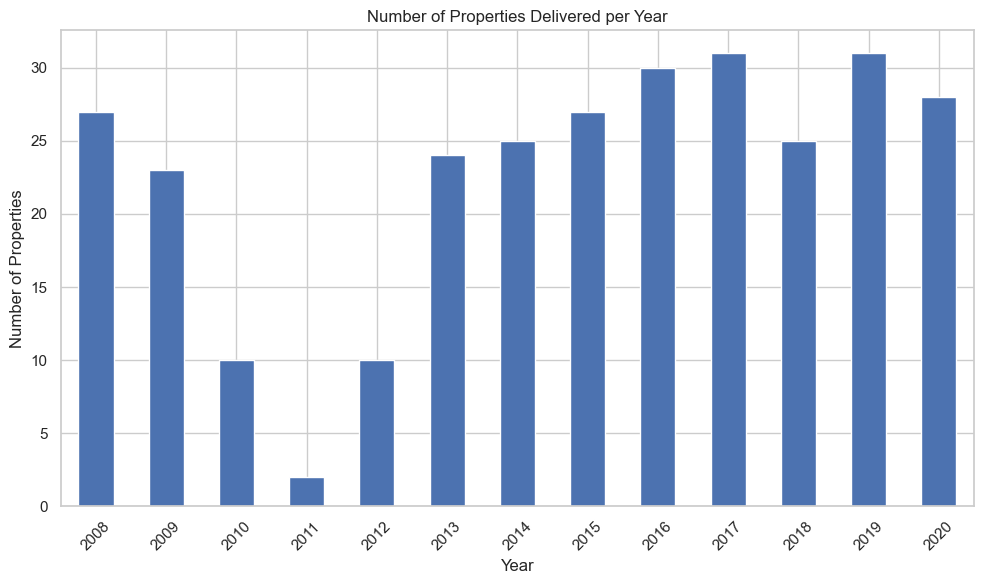

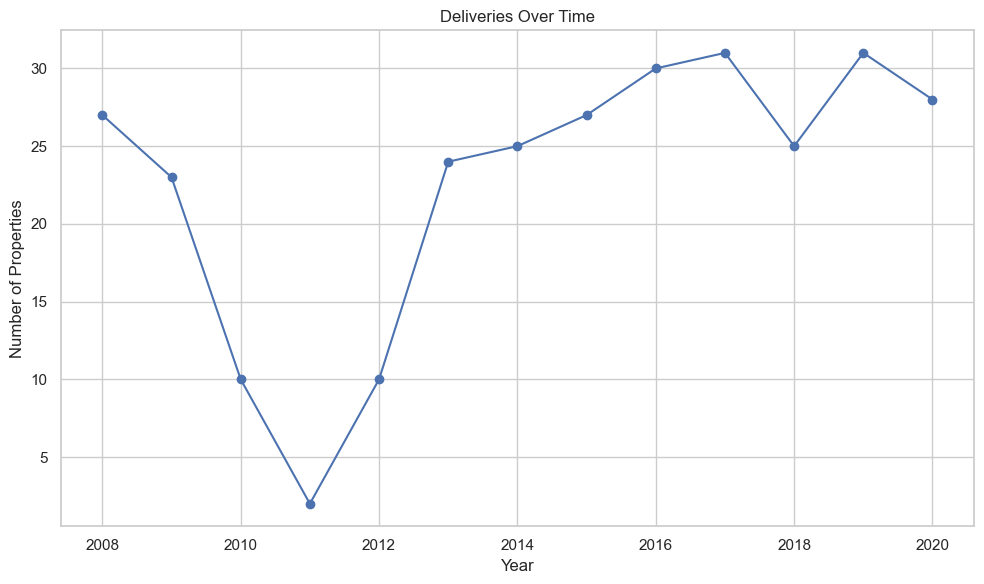

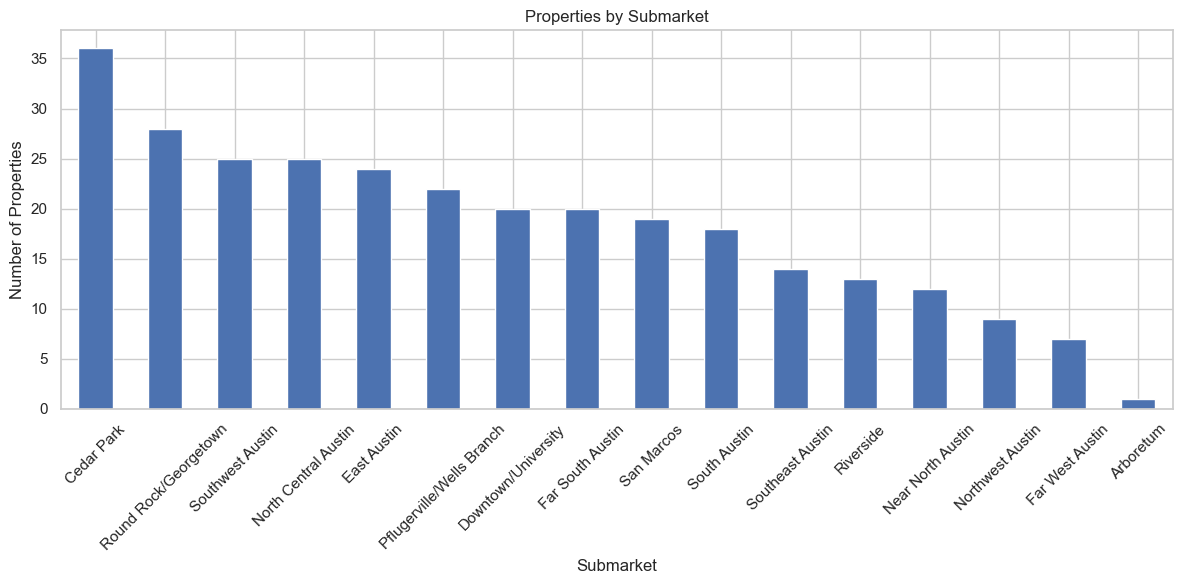

In [63]:
# Add delivery_year column for trend analysis
delivered_properties_df_1['delivery_year'] = delivered_properties_df_1['delivery_date'].dt.year

# Delivered Properties per Year - Bar Plot
deliveries_per_year = delivered_properties_df_1['delivery_year'].value_counts(
).sort_index()

plt.figure(figsize=(10, 6))
deliveries_per_year.plot(kind='bar')
plt.title('Number of Properties Delivered per Year')
plt.xlabel('Year')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Delivered Properties Over Time - Line Plot
plt.figure(figsize=(10, 6))
deliveries_per_year.plot(kind='line', marker='o')
plt.title('Deliveries Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Properties')
plt.grid(True)
plt.tight_layout()
plt.show()

# Submarket or Region Distribution - Bar Plot (only if present)
region_cols = ['Submarket', 'Market', 'Region', 'City']
for col in region_cols:
    if col in delivered_properties_df_1.columns:
        plt.figure(figsize=(12, 6))
        delivered_properties_df_1[col].value_counts().plot(kind='bar')
        plt.title(f'Properties by {col}')
        plt.xlabel(col)
        plt.ylabel('Number of Properties')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        break

In [64]:
merged_df_2 = merge_sheets(
    excel_file_path="MSA2.xlsx"
)

In [65]:
# Check the shape (rows and columns)
print("Shape of merged DataFrame:", merged_df_2.shape)

# Show the first few rows to inspect the data
print("\nFirst few rows:")
print(merged_df_2.head())

# List all column names
print("\nColumns in the DataFrame:")
print(merged_df_2.columns.tolist())

# Check for duplicate rows
num_duplicates = merged_df_2.duplicated().sum()
print("\nNumber of duplicate rows:", num_duplicates)

# Count missing (NaN) values for each column
print("\nNumber of missing values per column:")
print(merged_df_2.isnull().sum())

# Show the percentage of missing values per column
print("\nPercentage of missing values per column:")
print(merged_df_2.isnull().mean() * 100)

# Display the data types of each column
print("\nData types of each column:")
print(merged_df_2.dtypes)

# Show descriptive statistics for numeric columns
print("\nDescriptive statistics for numeric columns:")
print(merged_df_2.describe())

# Identify rows that contain at least one missing value
rows_with_nulls = merged_df_2[merged_df_2.isnull().any(axis=1)]
print("\nNumber of rows with at least one missing value:",
      rows_with_nulls.shape[0])

# drop columns with more than 50% missing values
threshold = len(merged_df_2) * 0.5
merged_df_2_cleaned = merged_df_2.dropna(axis=1, thresh=threshold)
print("\nShape after dropping columns with more than 50% missing values:",
      merged_df_2_cleaned.shape)

Shape of merged DataFrame: (99, 1526)

First few rows:
  MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
0      10420  Akron, OH        OH      Ohio        153     Summit  508000.0   
1      10420  Akron, OH        OH      Ohio        153     Summit  530104.0   
2      10420  Akron, OH        OH      Ohio        133    Portage  601701.0   
3      10420  Akron, OH        OH      Ohio        153     Summit  533501.0   
4      10420  Akron, OH        OH      Ohio        153     Summit  507500.0   

  BlockGroupCode  Latitude  Longitude           True Owner  \
0            1.0  41.13897  -81.54019       Bernard Busson   
1            4.0  41.31766  -81.44473    Gross Residential   
2            1.0  41.10999  -81.35435  Omni Properties LLC   
3            2.0   41.1277  -81.65665      Stile Companies   
4            1.0  41.13701  -81.54175    Beztak Properties   

     ManagementCompany ProjID            Submarket  \
0  Ali Properties, LLC  17225  South Summit

In [66]:
delivered_properties_df_2 = delivered_properties(merged_df_2)

In [67]:
# Check the shape (rows and columns)
print("Shape of delivered properties DataFrame:",
      delivered_properties_df_2.shape)

# Show the first few rows to inspect the delivery info
print("\nFirst few rows:")
print(delivered_properties_df_2.head())

# List all column names
print("\nColumns in the delivered properties DataFrame:")
print(delivered_properties_df_2.columns.tolist())

# Check for duplicate rows
num_duplicates = delivered_properties_df_2.duplicated().sum()
print("\nNumber of duplicate rows:", num_duplicates)

# Count missing (NaN) values for each column
print("\nNumber of missing values per column:")
print(delivered_properties_df_2.isnull().sum())

# Show the percentage of missing values per column
print("\nPercentage of missing values per column:")
print(delivered_properties_df_2.isnull().mean() * 100)

# Display the data types of each column
print("\nData types of each column:")
print(delivered_properties_df_2.dtypes)

# Show descriptive statistics for numeric columns
print("\nDescriptive statistics for numeric columns:")
print(delivered_properties_df_2.describe())

# Identify rows that contain at least one missing value
rows_with_nulls = delivered_properties_df_2[delivered_properties_df_2.isnull(
).any(axis=1)]
print("\nNumber of rows with at least one missing value:",
      rows_with_nulls.shape[0])

# Check unique values in the delivery_status column to confirm only LU and UC/LU are present
print("\nUnique values in delivery_status column:")
print(delivered_properties_df_2['delivery_status'].unique())

# Check minimum and maximum delivery dates to verify the filter worked
print("\nMinimum and maximum delivery dates:")
print("Min:", delivered_properties_df_2['delivery_date'].min())
print("Max:", delivered_properties_df_2['delivery_date'].max())

Shape of delivered properties DataFrame: (5, 1528)

First few rows:
   MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
2       10420  Akron, OH        OH      Ohio        133    Portage  601701.0   
27      10420  Akron, OH        OH      Ohio        153     Summit  530902.0   
67      10420  Akron, OH        OH      Ohio        153     Summit  502500.0   
78      10420  Akron, OH        OH      Ohio        153     Summit  508301.0   
88      10420  Akron, OH        OH      Ohio        153     Summit  509000.0   

   BlockGroupCode  Latitude  Longitude                True Owner  \
2             1.0  41.10999  -81.35435       Omni Properties LLC   
27            3.0  41.08548  -81.43438  PREMIER DEVELOPMENTS LLC   
67            2.0  41.06638  -81.48264  IRG Realty Advisors, LLC   
78            1.0  41.08116  -81.51936         Bower Development   
88            1.0  41.07457  -81.49274                       nan   

           ManagementCompany    ProjID    

In [68]:
delivered_properties_df_2[['ProjID', 'Name',
                           'delivery_status', 'delivery_date']].head()

ProjID                    Name delivery_status delivery_date
2      92308            Copper Creek           UC/LU    2018-05-01
27     47913            Colony Hills              LU    2017-09-01
67     51333     East End Residences              LU    2016-01-01
78     87610         Bowery District              LU    2020-03-01
88  10258733  797 Residence & Suites              LU    2020-06-01

In [69]:
# Check unique delivery statuses
print("Delivery statuses:",
      delivered_properties_df_2['delivery_status'].unique())

# Earliest and latest delivery dates
print("Delivery date range:", delivered_properties_df_2['delivery_date'].min(
), "to", delivered_properties_df_2['delivery_date'].max())

# Check counts by market or submarket if available
region_cols = ['Market', 'Submarket', 'Region', 'City']
found_region_col = None

for col in region_cols:
    if col in delivered_properties_df_2.columns:
        found_region_col = col
        print(f"\nCounts by {col}:")
        print(delivered_properties_df_2[col].value_counts())
        break

if not found_region_col:
    print("\nNo region column (like Market, Submarket, Region, City) found in delivered_properties_df_2.")

# Spot check a few rows
print("\nRandom sample of delivered properties:")
print(delivered_properties_df_2.sample(5))

Delivery statuses: ['UC/LU' 'LU']
Delivery date range: 2016-01-01 00:00:00 to 2020-06-01 00:00:00

Counts by Submarket:
Submarket
South Summit County    4
Kent/Portage County    1
Name: count, dtype: int64

Random sample of delivered properties:
   MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
67      10420  Akron, OH        OH      Ohio        153     Summit  502500.0   
78      10420  Akron, OH        OH      Ohio        153     Summit  508301.0   
88      10420  Akron, OH        OH      Ohio        153     Summit  509000.0   
27      10420  Akron, OH        OH      Ohio        153     Summit  530902.0   
2       10420  Akron, OH        OH      Ohio        133    Portage  601701.0   

   BlockGroupCode  Latitude  Longitude                True Owner  \
67            2.0  41.06638  -81.48264  IRG Realty Advisors, LLC   
78            1.0  41.08116  -81.51936         Bower Development   
88            1.0  41.07457  -81.49274                       nan   
2

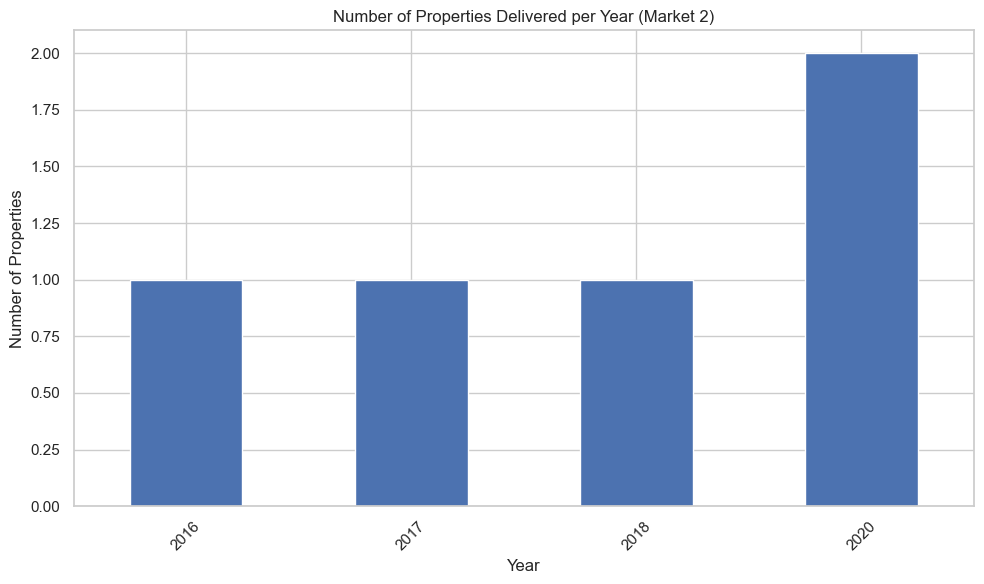

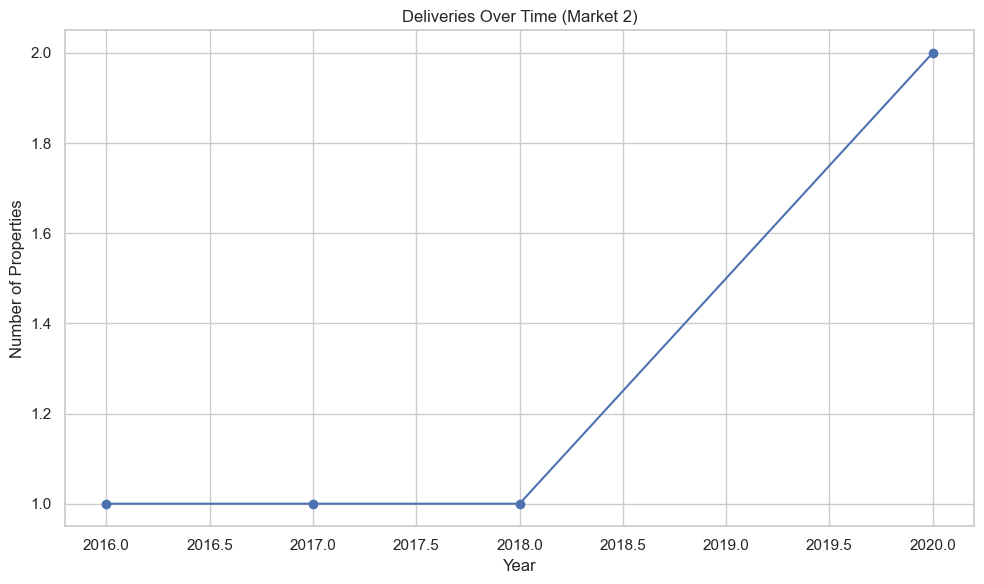

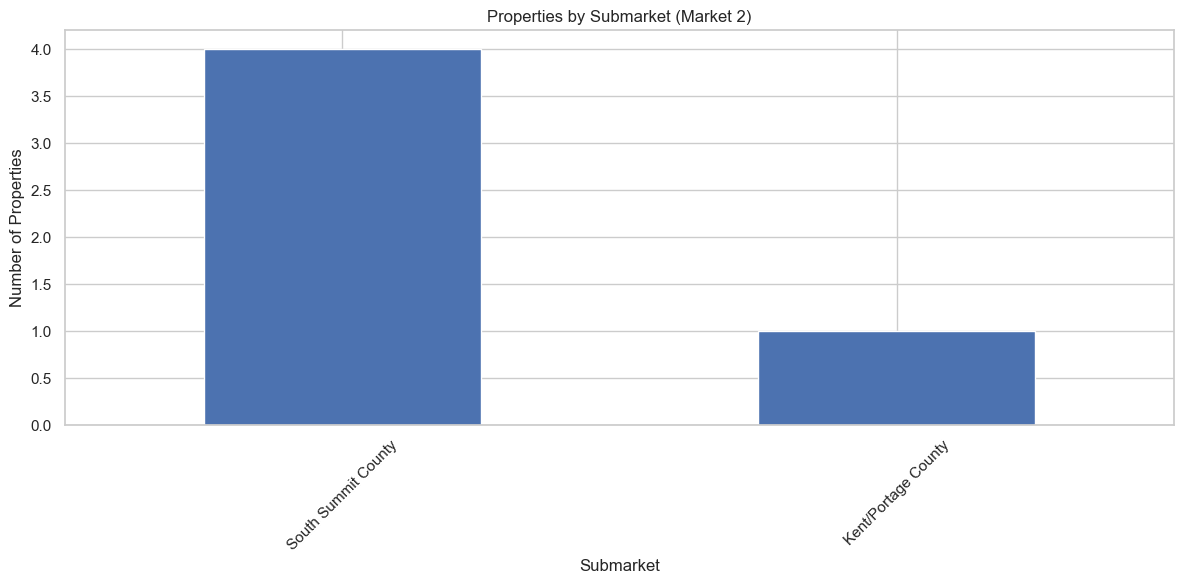

In [70]:
# Add delivery_year column for trend analysis
delivered_properties_df_2['delivery_year'] = delivered_properties_df_2['delivery_date'].dt.year

# Delivered Properties per Year - Bar Plot
deliveries_per_year = delivered_properties_df_2['delivery_year'].value_counts(
).sort_index()

plt.figure(figsize=(10, 6))
deliveries_per_year.plot(kind='bar')
plt.title('Number of Properties Delivered per Year (Market 2)')
plt.xlabel('Year')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Delivered Properties Over Time - Line Plot
plt.figure(figsize=(10, 6))
deliveries_per_year.plot(kind='line', marker='o')
plt.title('Deliveries Over Time (Market 2)')
plt.xlabel('Year')
plt.ylabel('Number of Properties')
plt.grid(True)
plt.tight_layout()
plt.show()

# Submarket or Region Distribution - Bar Plot (only if present)
region_cols = ['Submarket', 'Market', 'Region', 'City']
for col in region_cols:
    if col in delivered_properties_df_2.columns:
        plt.figure(figsize=(12, 6))
        delivered_properties_df_2[col].value_counts().plot(kind='bar')
        plt.title(f'Properties by {col} (Market 2)')
        plt.xlabel(col)
        plt.ylabel('Number of Properties')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        break

## Calculate the average lease-up time for these markets.

In [71]:
def compute_leaseup_time(df):
    """
    Computes the lease-up time for each property in the DataFrame.
    Lease-up time = number of months from delivery date to first month when occupancy reaches at least 90%.

    This version is self-contained:
    - Extracts and sorts occupancy columns internally (no external helper needed).
    - Computes lease-up time and which occupancy column first reached 90%.
    - Returns a DataFrame with added 'leaseup_time' and 'leaseup_occ_col' columns.

    Args:
        df (pd.DataFrame): The delivered properties DataFrame with OCC_ columns.

    Returns:
        pd.DataFrame: Original DataFrame plus lease-up info.
    """

    # Extract all columns that start with 'OCC_'
    occ_cols = [col for col in df.columns if col.startswith("OCC_")]

    # Convert the list to a Series and parse the date portion
    col_series = pd.Series(occ_cols)
    dates = (
        col_series
        .str.replace(r'^OCC_', '', regex=True)
        .str.split('.').str[0]
        .apply(lambda s: pd.to_datetime(s, format='%b-%y', errors='coerce'))
    )

    # Create a DataFrame of columns and their parsed dates, drop invalid dates, and sort
    sorted_df = (
        pd.DataFrame({'col': col_series, 'date': dates})
        .dropna(subset=['date'])
        .sort_values('date')
    )

    # Get the sorted list of occupancy columns
    sorted_occ_cols = sorted_df['col'].tolist()

    # Build a mapping from each occupancy column to its actual date
    occ_col_dates = {
        col: pd.to_datetime(col.replace(
            'OCC_', '').split('.')[0], format='%b-%y')
        for col in sorted_occ_cols
    }

    # Define a function to compute lease-up time for a single row
    def row_leaseup(row):
        delivery_date = row['delivery_date']
        for col in sorted_occ_cols:
            val = row[col]
            if isinstance(val, str):
                val = val.strip().replace('%', '')
                try:
                    val = float(val)
                except:
                    val = np.nan
            if pd.notna(val) and val >= 90:
                occ_date = occ_col_dates[col]
                delta = relativedelta(occ_date, delivery_date)
                leaseup_months = delta.years * 12 + delta.months
                return pd.Series([leaseup_months, col])
        return pd.Series([np.nan, None])

    # Apply the function to all rows
    leaseup_info = df.apply(row_leaseup, axis=1)
    leaseup_info.columns = ['leaseup_time', 'leaseup_occ_col']

    # Copy the original DataFrame and add the new columns
    df_out = df.copy()
    df_out[['leaseup_time', 'leaseup_occ_col']] = leaseup_info

    return df_out

In [72]:
leaseup_df1 = compute_leaseup_time(delivered_properties_df_1)

In [73]:
print("Shape of leaseup_df1:", leaseup_df1.shape)
print("Columns:", leaseup_df1.columns.tolist())

print("\nMissing lease-up times:", leaseup_df1['leaseup_time'].isnull().sum())

print("\nLease-up time descriptive statistics (months):")
print(leaseup_df1['leaseup_time'].describe())

print("\nOverall average lease-up time (months):",
      round(leaseup_df1['leaseup_time'].mean(), 2))

print("\nUnique delivery statuses:")
print(leaseup_df1['delivery_status'].unique())

Shape of leaseup_df1: (293, 1531)
Columns: ['MarketCode', 'MarketName', 'StateCode', 'StateName', 'CountyCode', 'CountyName', 'TractCode', 'BlockGroupCode', 'Latitude', 'Longitude', 'True Owner', 'ManagementCompany', 'ProjID', 'Submarket', 'Name', 'Address', 'City', 'State', 'Zip', 'Phone', 'YearBuilt', 'Rehab1', 'Quantity', 'AreaPerUnit', 'Level', 'Status', 'RENT_Apr-08', 'RENT_May-08', 'RENT_Jun-08', 'RENT_Jul-08', 'RENT_Aug-08', 'RENT_Sep-08', 'RENT_Oct-08', 'RENT_Nov-08', 'RENT_Dec-08', 'RENT_Jan-09', 'RENT_Feb-09', 'RENT_Mar-09', 'RENT_Apr-09', 'RENT_May-09', 'RENT_Jun-09', 'RENT_Jul-09', 'RENT_Aug-09', 'RENT_Sep-09', 'RENT_Oct-09', 'RENT_Nov-09', 'RENT_Dec-09', 'RENT_Jan-10', 'RENT_Feb-10', 'RENT_Mar-10', 'RENT_Apr-10', 'RENT_May-10', 'RENT_Jun-10', 'RENT_Jul-10', 'RENT_Aug-10', 'RENT_Sep-10', 'RENT_Oct-10', 'RENT_Nov-10', 'RENT_Dec-10', 'RENT_Jan-11', 'RENT_Feb-11', 'RENT_Mar-11', 'RENT_Apr-11', 'RENT_May-11', 'RENT_Jun-11', 'RENT_Jul-11', 'RENT_Aug-11', 'RENT_Sep-11', 'RENT_Oct

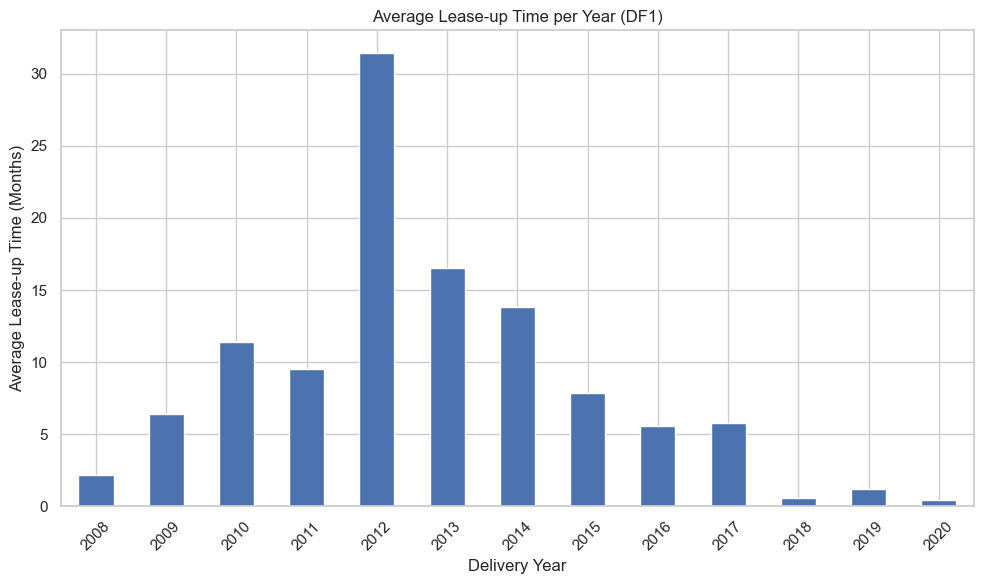

/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


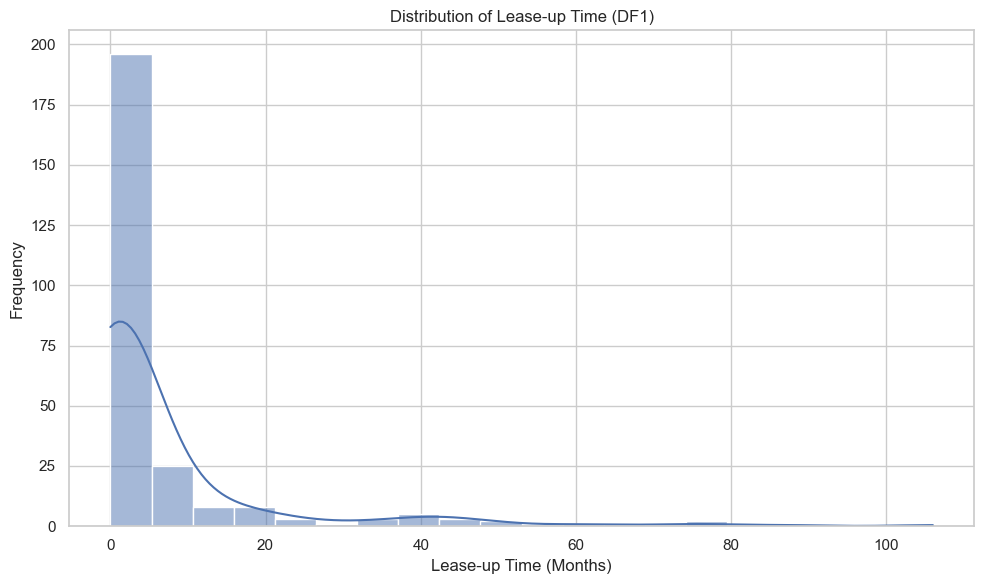

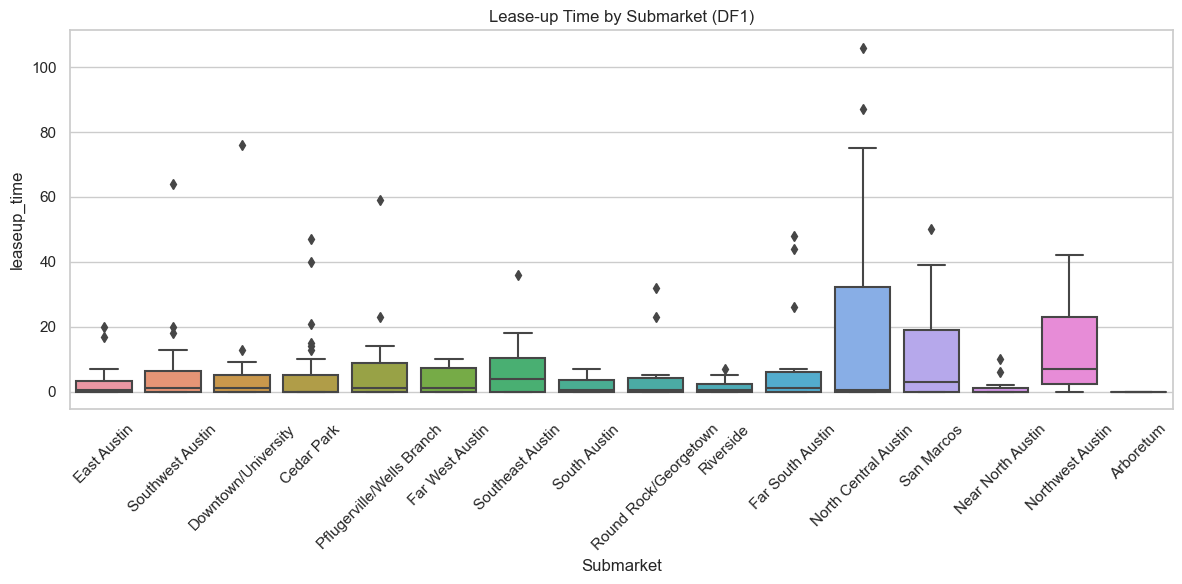

In [74]:
# Ensure delivery_year exists
leaseup_df1['delivery_year'] = leaseup_df1['delivery_date'].dt.year

# Average lease-up time per delivery year
avg_leaseup_per_year = leaseup_df1.groupby(
    'delivery_year')['leaseup_time'].mean()

plt.figure(figsize=(10, 6))
avg_leaseup_per_year.plot(kind='bar')
plt.title('Average Lease-up Time per Year (DF1)')
plt.xlabel('Delivery Year')
plt.ylabel('Average Lease-up Time (Months)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histogram of lease-up time distribution
plt.figure(figsize=(10, 6))
sns.histplot(leaseup_df1['leaseup_time'].dropna(), bins=20, kde=True)
plt.title('Distribution of Lease-up Time (DF1)')
plt.xlabel('Lease-up Time (Months)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Boxplot by submarket if exists
region_cols = ['Submarket', 'Market', 'Region', 'City']
found_region_col = None

for col in region_cols:
    if col in leaseup_df1.columns:
        found_region_col = col
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=leaseup_df1, x=col, y='leaseup_time')
        plt.title(f'Lease-up Time by {col} (DF1)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        break

if not found_region_col:
    print("\nNo region column found for boxplot.")

In [75]:
leaseup_df2 = compute_leaseup_time(delivered_properties_df_2)

In [76]:
print("Shape of leaseup_df2:", leaseup_df2.shape)
print("Columns:", leaseup_df2.columns.tolist())

print("\nMissing lease-up times:", leaseup_df2['leaseup_time'].isnull().sum())

print("\nLease-up time descriptive statistics (months):")
print(leaseup_df2['leaseup_time'].describe())

print("\nOverall average lease-up time (months):",
      round(leaseup_df2['leaseup_time'].mean(), 2))

print("\nUnique delivery statuses:")
print(leaseup_df2['delivery_status'].unique())

Shape of leaseup_df2: (5, 1531)
Columns: ['MarketCode', 'MarketName', 'StateCode', 'StateName', 'CountyCode', 'CountyName', 'TractCode', 'BlockGroupCode', 'Latitude', 'Longitude', 'True Owner', 'ManagementCompany', 'ProjID', 'Submarket', 'Name', 'Address', 'City', 'State', 'Zip', 'Phone', 'YearBuilt', 'Rehab1', 'Quantity', 'AreaPerUnit', 'Level', 'Status', 'RENT_Apr-08', 'RENT_May-08', 'RENT_Jun-08', 'RENT_Jul-08', 'RENT_Aug-08', 'RENT_Sep-08', 'RENT_Oct-08', 'RENT_Nov-08', 'RENT_Dec-08', 'RENT_Jan-09', 'RENT_Feb-09', 'RENT_Mar-09', 'RENT_Apr-09', 'RENT_May-09', 'RENT_Jun-09', 'RENT_Jul-09', 'RENT_Aug-09', 'RENT_Sep-09', 'RENT_Oct-09', 'RENT_Nov-09', 'RENT_Dec-09', 'RENT_Jan-10', 'RENT_Feb-10', 'RENT_Mar-10', 'RENT_Apr-10', 'RENT_May-10', 'RENT_Jun-10', 'RENT_Jul-10', 'RENT_Aug-10', 'RENT_Sep-10', 'RENT_Oct-10', 'RENT_Nov-10', 'RENT_Dec-10', 'RENT_Jan-11', 'RENT_Feb-11', 'RENT_Mar-11', 'RENT_Apr-11', 'RENT_May-11', 'RENT_Jun-11', 'RENT_Jul-11', 'RENT_Aug-11', 'RENT_Sep-11', 'RENT_Oct-1

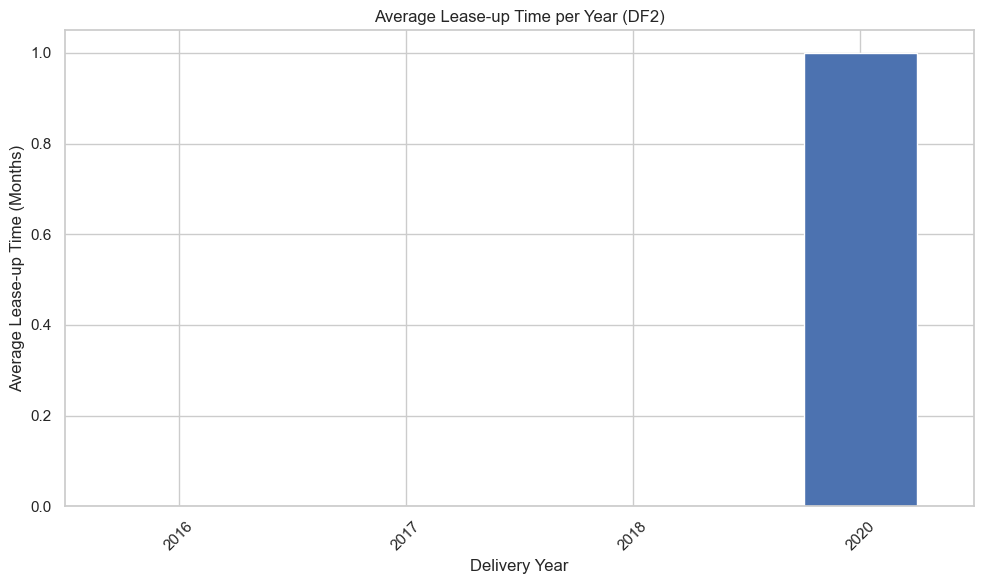

/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


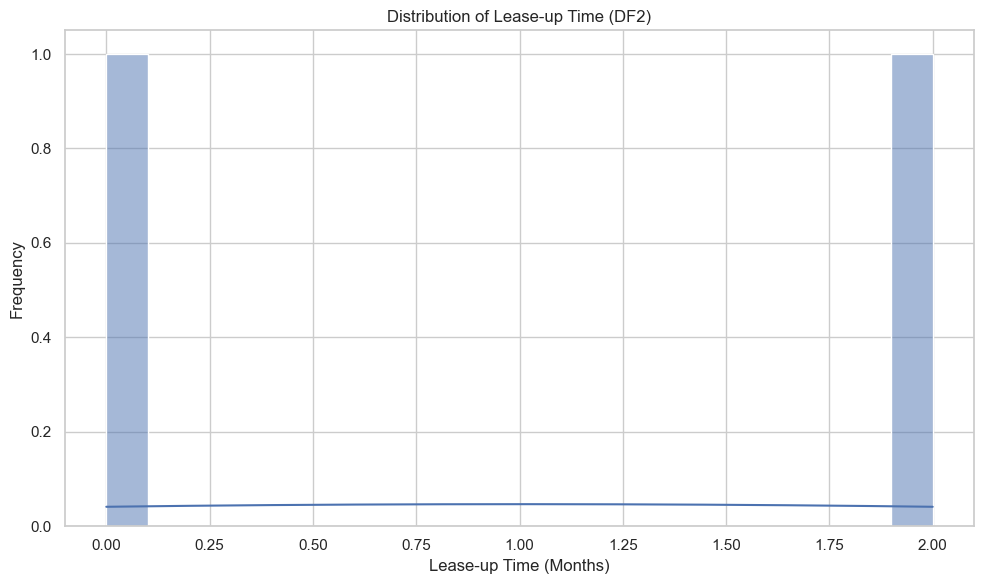

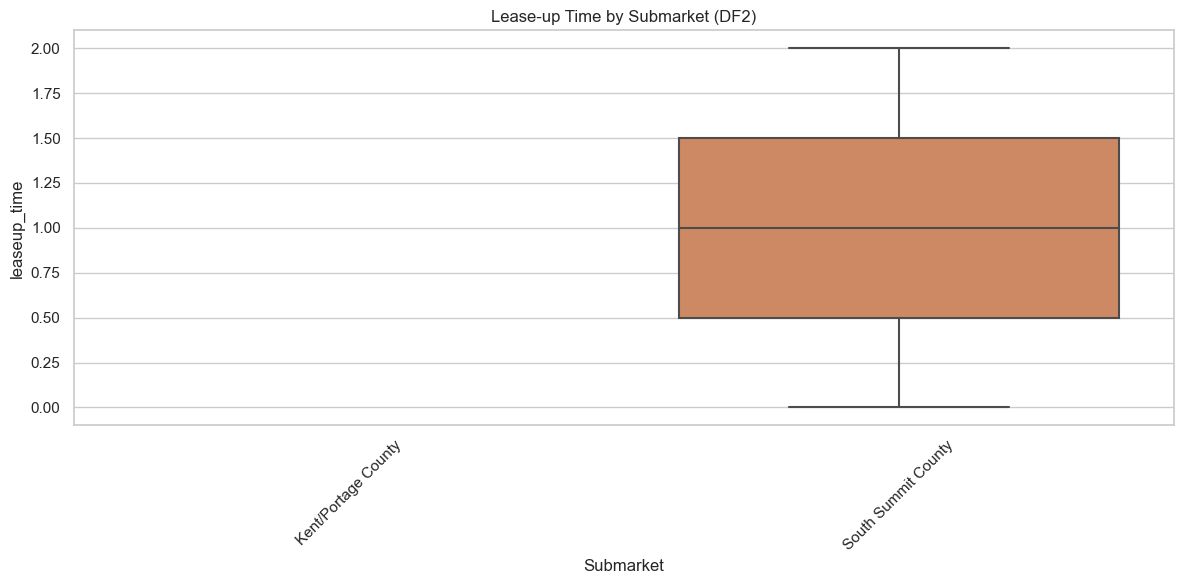

In [77]:
# Ensure delivery_year exists
leaseup_df2['delivery_year'] = leaseup_df2['delivery_date'].dt.year

# Average lease-up time per delivery year
avg_leaseup_per_year = leaseup_df2.groupby(
    'delivery_year')['leaseup_time'].mean()

plt.figure(figsize=(10, 6))
avg_leaseup_per_year.plot(kind='bar')
plt.title('Average Lease-up Time per Year (DF2)')
plt.xlabel('Delivery Year')
plt.ylabel('Average Lease-up Time (Months)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histogram of lease-up time distribution
plt.figure(figsize=(10, 6))
sns.histplot(leaseup_df2['leaseup_time'].dropna(), bins=20, kde=True)
plt.title('Distribution of Lease-up Time (DF2)')
plt.xlabel('Lease-up Time (Months)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Boxplot by submarket if exists
region_cols = ['Submarket', 'Market', 'Region', 'City']
found_region_col = None

for col in region_cols:
    if col in leaseup_df2.columns:
        found_region_col = col
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=leaseup_df2, x=col, y='leaseup_time')
        plt.title(f'Lease-up Time by {col} (DF2)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        break

if not found_region_col:
    print("\nNo region column found for boxplot.")

## Determine which properties had negative effective rent growth during lease-up.

In [78]:
def compute_rent_growth(df):
    """
    Computes effective rent at delivery and at lease-up,
    their difference, and flags if growth was negative.

    This version is fully self-contained:
    - It finds the RENT column for the delivery month
    - It finds the RENT column for the lease-up month (from leaseup_occ_col)
    - It cleans rent values and computes the difference
    - It flags if the growth is negative
    - It returns a copy of the DataFrame with new columns:
      'effective_rent_delivery', 'effective_rent_leaseup',
      'effective_rent_growth', and 'negative_growth'

    Args:
        df (pd.DataFrame): Delivered properties DataFrame with occupancy and rent columns.

    Returns:
        pd.DataFrame: Original DataFrame with rent growth details added.
    """

    def parse_rent(val):
        """Clean and convert rent value to float."""
        try:
            return float(str(val).replace("$", "").replace(",", "").strip())
        except:
            return np.nan

    def get_effective_rent_at_month(row, prefix, dt):
        """
        For a given row and datetime, find the rent for that month.
        Looks for exact column or first column that starts with that month string.
        """
        base = f"{prefix}{dt.strftime('%b-%y')}"
        if base in row.index:
            return row.at[base]
        matches = [col for col in row.index if col.startswith(base)]
        return row.at[matches[0]] if matches else np.nan

    def row_rent_growth(row):
        # Get rent at delivery month
        rent_delivery = get_effective_rent_at_month(
            row, "RENT_", row['delivery_date'])

        # Get rent at lease-up month using leaseup_occ_col
        leaseup_col = row['leaseup_occ_col']
        if pd.notna(leaseup_col):
            rent_leaseup_col = "RENT_" + leaseup_col[len("OCC_"):]
            rent_leaseup = row.get(rent_leaseup_col, np.nan)
        else:
            rent_leaseup = np.nan

        # Clean and convert both
        rent_delivery_val = parse_rent(rent_delivery)
        rent_leaseup_val = parse_rent(rent_leaseup)

        # Compute growth and flag negative growth
        if pd.notna(rent_delivery_val) and pd.notna(rent_leaseup_val):
            growth = rent_leaseup_val - rent_delivery_val
            negative = growth < 0
        else:
            growth = np.nan
            negative = False

        return pd.Series([rent_delivery_val, rent_leaseup_val, growth, negative])

    rent_info = df.apply(row_rent_growth, axis=1)
    rent_info.columns = [
        "effective_rent_delivery",
        "effective_rent_leaseup",
        "effective_rent_growth",
        "negative_growth"
    ]

    df_out = df.copy()
    df_out = df_out.join(rent_info)

    return df_out

In [79]:
rent_growth_df1 = compute_rent_growth(leaseup_df1)
# Filter negative growth
negative_growth_df1 = rent_growth_df1[rent_growth_df1['negative_growth']]
print("Number of properties with negative rent growth:", len(negative_growth_df1))
negative_growth_df1[[
    "ProjID", "Name",
    "effective_rent_delivery",
    "effective_rent_leaseup",
    "effective_rent_growth",
    "negative_growth"
]].head()

Number of properties with negative rent growth: 242


ProjID               Name  effective_rent_delivery  effective_rent_leaseup  \
2   70636       Davies Ranch                   1347.0                  1250.0   
4   82343     The Saint Mary                   1576.0                  1385.0   
7   37791  Gables Park Tower                   2802.0                  2605.0   
8   64806    AMLI on Aldrich                   2091.0                  1967.0   
12  90323    Hermosa Village                   1488.0                  1367.0   

    effective_rent_growth  negative_growth  
2                   -97.0             True  
4                  -191.0             True  
7                  -197.0             True  
8                  -124.0             True  
12                 -121.0             True

In [80]:
# Check shape and new columns
print("Shape of rent_growth_df1:", rent_growth_df1.shape)
print("Columns:", rent_growth_df1.columns.tolist())

# How many properties have negative rent growth
counts = rent_growth_df1['negative_growth'].value_counts()
print("Properties with negative growth (True):", counts.get(True, 0))
print("Properties with positive or zero growth (False):", counts.get(False, 0))

# Basic stats for rent at delivery and lease-up
print("\nDescriptive stats for delivery rent:")
print(rent_growth_df1['effective_rent_delivery'].describe())

print("\nDescriptive stats for lease-up rent:")
print(rent_growth_df1['effective_rent_leaseup'].describe())

print("\nDescriptive stats for rent growth:")
print(rent_growth_df1['effective_rent_growth'].describe())

# Peek at properties with negative growth
print("\nSample of properties with negative rent growth:")
print(rent_growth_df1[rent_growth_df1['negative_growth']][[
      'ProjID', 'Name', 'effective_rent_delivery', 'effective_rent_leaseup', 'effective_rent_growth']].head())

Shape of rent_growth_df1: (293, 1535)
Columns: ['MarketCode', 'MarketName', 'StateCode', 'StateName', 'CountyCode', 'CountyName', 'TractCode', 'BlockGroupCode', 'Latitude', 'Longitude', 'True Owner', 'ManagementCompany', 'ProjID', 'Submarket', 'Name', 'Address', 'City', 'State', 'Zip', 'Phone', 'YearBuilt', 'Rehab1', 'Quantity', 'AreaPerUnit', 'Level', 'Status', 'RENT_Apr-08', 'RENT_May-08', 'RENT_Jun-08', 'RENT_Jul-08', 'RENT_Aug-08', 'RENT_Sep-08', 'RENT_Oct-08', 'RENT_Nov-08', 'RENT_Dec-08', 'RENT_Jan-09', 'RENT_Feb-09', 'RENT_Mar-09', 'RENT_Apr-09', 'RENT_May-09', 'RENT_Jun-09', 'RENT_Jul-09', 'RENT_Aug-09', 'RENT_Sep-09', 'RENT_Oct-09', 'RENT_Nov-09', 'RENT_Dec-09', 'RENT_Jan-10', 'RENT_Feb-10', 'RENT_Mar-10', 'RENT_Apr-10', 'RENT_May-10', 'RENT_Jun-10', 'RENT_Jul-10', 'RENT_Aug-10', 'RENT_Sep-10', 'RENT_Oct-10', 'RENT_Nov-10', 'RENT_Dec-10', 'RENT_Jan-11', 'RENT_Feb-11', 'RENT_Mar-11', 'RENT_Apr-11', 'RENT_May-11', 'RENT_Jun-11', 'RENT_Jul-11', 'RENT_Aug-11', 'RENT_Sep-11', 'RENT

/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


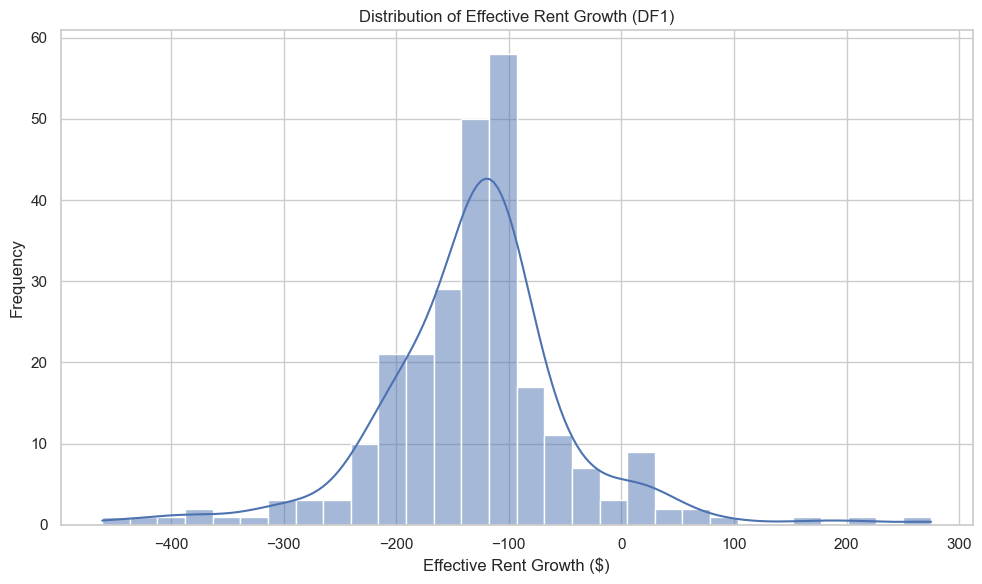

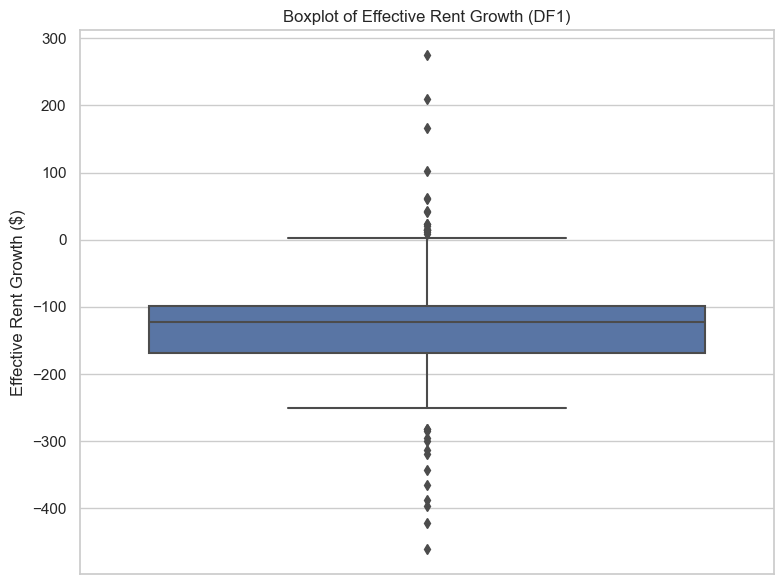

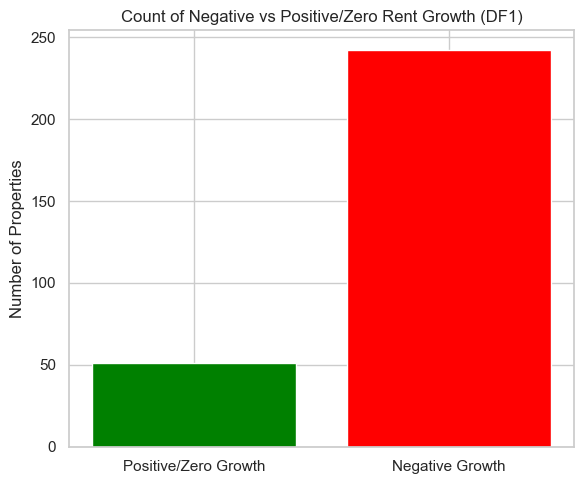

Positive/Zero Growth: 51, Negative Growth: 242


In [81]:
# Histogram of rent growth values
plt.figure(figsize=(10, 6))
sns.histplot(
    rent_growth_df1['effective_rent_growth'].dropna(), bins=30, kde=True)
plt.title('Distribution of Effective Rent Growth (DF1)')
plt.xlabel('Effective Rent Growth ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Boxplot to see spread and outliers
plt.figure(figsize=(8, 6))
sns.boxplot(y=rent_growth_df1['effective_rent_growth'].dropna())
plt.title('Boxplot of Effective Rent Growth (DF1)')
plt.ylabel('Effective Rent Growth ($)')
plt.tight_layout()
plt.show()

# Get exact counts
counts = rent_growth_df1['negative_growth'].value_counts()

# Build new Series with meaningful labels
labels = ['Positive/Zero Growth', 'Negative Growth']
values = [counts.get(False, 0), counts.get(True, 0)]

# Plot
plt.figure(figsize=(6, 5))
plt.bar(labels, values, color=['green', 'red'])
plt.title('Count of Negative vs Positive/Zero Rent Growth (DF1)')
plt.ylabel('Number of Properties')
plt.tight_layout()
plt.show()

print(f"Positive/Zero Growth: {values[0]}, Negative Growth: {values[1]}")

In [82]:
rent_growth_df2 = compute_rent_growth(leaseup_df2)
negative_growth_df2 = rent_growth_df2[rent_growth_df2['negative_growth']]
print("Number of properties with negative rent growth:", len(negative_growth_df2))
negative_growth_df2[[
    "ProjID", "Name",
    "effective_rent_delivery",
    "effective_rent_leaseup",
    "effective_rent_growth",
    "negative_growth"
]].head()

Number of properties with negative rent growth: 1


ProjID             Name  effective_rent_delivery  effective_rent_leaseup  \
78  87610  Bowery District                   1679.0                  1550.0   

    effective_rent_growth  negative_growth  
78                 -129.0             True

In [83]:
# EDA for DF2
print("Shape of rent_growth_df2:", rent_growth_df2.shape)
print("Columns:", rent_growth_df2.columns.tolist())

num_negative = rent_growth_df2['negative_growth'].sum()
print("\nNumber of properties with negative rent growth:", num_negative)

print("\nDescriptive stats for delivery rent:")
print(rent_growth_df2['effective_rent_delivery'].describe())

print("\nDescriptive stats for lease-up rent:")
print(rent_growth_df2['effective_rent_leaseup'].describe())

print("\nDescriptive stats for rent growth:")
print(rent_growth_df2['effective_rent_growth'].describe())

print("\nSample of properties with negative rent growth:")
print(rent_growth_df2[rent_growth_df2['negative_growth']][[
      'ProjID', 'Name', 'effective_rent_delivery', 'effective_rent_leaseup', 'effective_rent_growth']].head())

Shape of rent_growth_df2: (5, 1535)
Columns: ['MarketCode', 'MarketName', 'StateCode', 'StateName', 'CountyCode', 'CountyName', 'TractCode', 'BlockGroupCode', 'Latitude', 'Longitude', 'True Owner', 'ManagementCompany', 'ProjID', 'Submarket', 'Name', 'Address', 'City', 'State', 'Zip', 'Phone', 'YearBuilt', 'Rehab1', 'Quantity', 'AreaPerUnit', 'Level', 'Status', 'RENT_Apr-08', 'RENT_May-08', 'RENT_Jun-08', 'RENT_Jul-08', 'RENT_Aug-08', 'RENT_Sep-08', 'RENT_Oct-08', 'RENT_Nov-08', 'RENT_Dec-08', 'RENT_Jan-09', 'RENT_Feb-09', 'RENT_Mar-09', 'RENT_Apr-09', 'RENT_May-09', 'RENT_Jun-09', 'RENT_Jul-09', 'RENT_Aug-09', 'RENT_Sep-09', 'RENT_Oct-09', 'RENT_Nov-09', 'RENT_Dec-09', 'RENT_Jan-10', 'RENT_Feb-10', 'RENT_Mar-10', 'RENT_Apr-10', 'RENT_May-10', 'RENT_Jun-10', 'RENT_Jul-10', 'RENT_Aug-10', 'RENT_Sep-10', 'RENT_Oct-10', 'RENT_Nov-10', 'RENT_Dec-10', 'RENT_Jan-11', 'RENT_Feb-11', 'RENT_Mar-11', 'RENT_Apr-11', 'RENT_May-11', 'RENT_Jun-11', 'RENT_Jul-11', 'RENT_Aug-11', 'RENT_Sep-11', 'RENT_O

/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


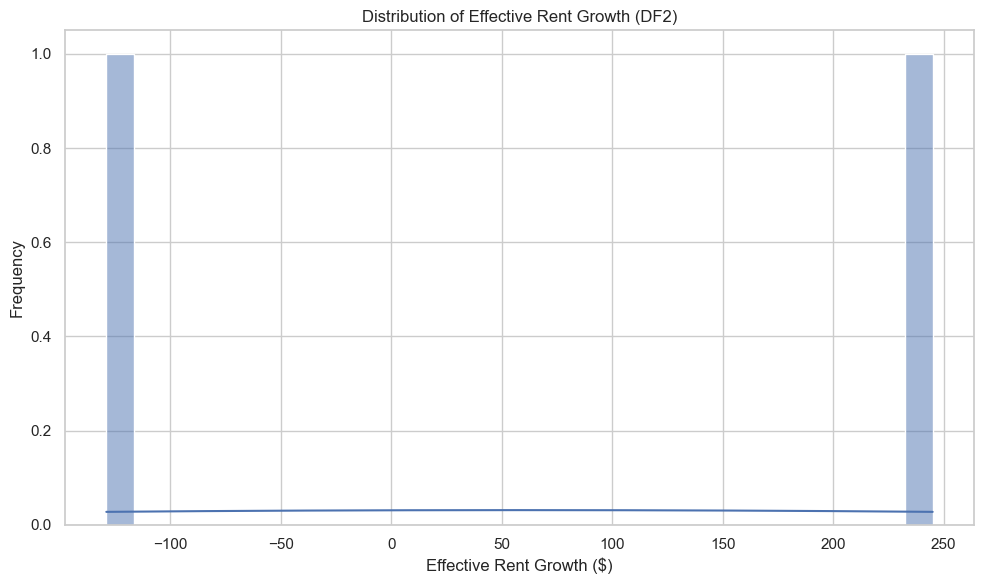

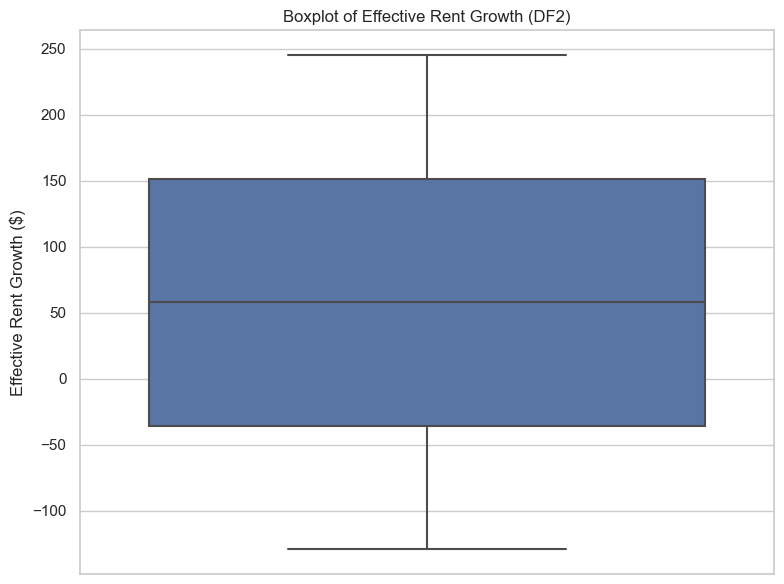

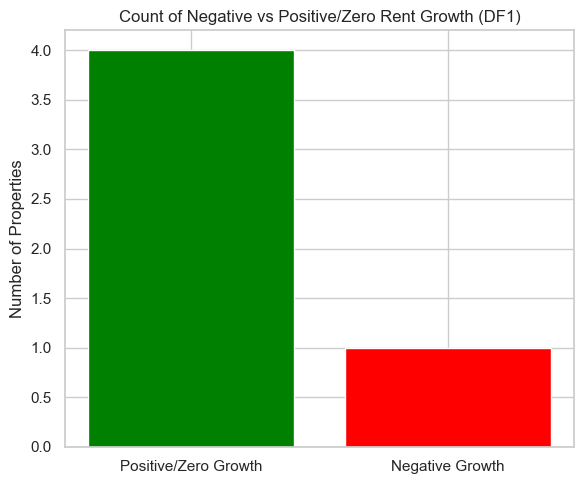

Positive/Zero Growth: 4, Negative Growth: 1


In [84]:
# Histogram of rent growth for DF2
plt.figure(figsize=(10, 6))
sns.histplot(
    rent_growth_df2['effective_rent_growth'].dropna(), bins=30, kde=True)
plt.title('Distribution of Effective Rent Growth (DF2)')
plt.xlabel('Effective Rent Growth ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Boxplot for DF2
plt.figure(figsize=(8, 6))
sns.boxplot(y=rent_growth_df2['effective_rent_growth'].dropna())
plt.title('Boxplot of Effective Rent Growth (DF2)')
plt.ylabel('Effective Rent Growth ($)')
plt.tight_layout()
plt.show()

# Get exact counts
counts = rent_growth_df2['negative_growth'].value_counts()

# Build new Series with meaningful labels
labels = ['Positive/Zero Growth', 'Negative Growth']
values = [counts.get(False, 0), counts.get(True, 0)]

# Plot
plt.figure(figsize=(6, 5))
plt.bar(labels, values, color=['green', 'red'])
plt.title('Count of Negative vs Positive/Zero Rent Growth (DF1)')
plt.ylabel('Number of Properties')
plt.tight_layout()
plt.show()

print(f"Positive/Zero Growth: {values[0]}, Negative Growth: {values[1]}")

##  Create at least 5 additional features from this dataset that could improve predictive modeling of lease-up time. Explain your reasoning for each feature.

In [85]:
# Ensure numeric columns
rent_growth_df1['YearBuilt'] = pd.to_numeric(
    rent_growth_df1['YearBuilt'], errors='coerce')
rent_growth_df1['Quantity'] = pd.to_numeric(
    rent_growth_df1['Quantity'], errors='coerce')
rent_growth_df1['Rehab1'] = pd.to_numeric(
    rent_growth_df1['Rehab1'], errors='coerce')

# Property age + bucket
rent_growth_df1['property_age'] = rent_growth_df1['delivery_date'].dt.year - \
    rent_growth_df1['YearBuilt']
rent_growth_df1['property_age_group'] = pd.cut(
    rent_growth_df1['property_age'],
    bins=[-1, 5, 20, 50, 200],
    labels=['0-5 years', '6-20 years', '21-50 years', '50+ years']
)

# Large project flag
rent_growth_df1['large_project_flag'] = (
    rent_growth_df1['Quantity'] >= 200).astype(int)

# Cyclical month encoding
rent_growth_df1['delivery_month'] = rent_growth_df1['delivery_date'].dt.month
rent_growth_df1['month_sin'] = np.sin(
    2 * np.pi * rent_growth_df1['delivery_month'] / 12)
rent_growth_df1['month_cos'] = np.cos(
    2 * np.pi * rent_growth_df1['delivery_month'] / 12)

# Rent per unit
rent_growth_df1['rent_per_unit'] = rent_growth_df1['effective_rent_delivery'] / \
    rent_growth_df1['Quantity']

# Rehab age (safe now!)
rent_growth_df1['rehab_age'] = np.where(
    rent_growth_df1['Rehab1'] > 0,
    rent_growth_df1['delivery_date'].dt.year - rent_growth_df1['Rehab1'],
    np.nan
)

# Initial occupancy & change
rent_growth_df1['initial_occupancy'] = rent_growth_df1.apply(
    lambda row: row.get(
        f"OCC_{row['delivery_date'].strftime('%b-%y')}", np.nan),
    axis=1
)
rent_growth_df1['occupancy_change_at_delivery'] = rent_growth_df1['initial_occupancy'].fillna(
    0)

# Submarket encoded
rent_growth_df1['submarket_encoded'] = rent_growth_df1['Submarket'].astype(
    'category').cat.codes

print("\n Engineered features for rent_growth_df1:")
print(rent_growth_df1[[
    'property_age', 'property_age_group', 'large_project_flag',
    'month_sin', 'month_cos', 'rent_per_unit',
    'rehab_age', 'occupancy_change_at_delivery',
    'submarket_encoded'
]].head())


 Engineered features for rent_growth_df1:
    property_age property_age_group  large_project_flag  month_sin  month_cos  \
2             -1                NaN                   1   0.866025  -0.500000   
4              0          0-5 years                   1  -0.866025  -0.500000   
7              0          0-5 years                   1   0.500000   0.866025   
8             -1                NaN                   1  -0.866025   0.500000   
12            -1                NaN                   1  -0.866025   0.500000   

    rent_per_unit  rehab_age  occupancy_change_at_delivery  submarket_encoded  
2        3.741667        NaN                         0.019                  3  
4        6.566667        NaN                         0.050                 15  
7       12.565022        NaN                         0.121                  2  
8        6.575472        NaN                         0.031                  3  
12       6.252101        NaN                         0.016            

/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


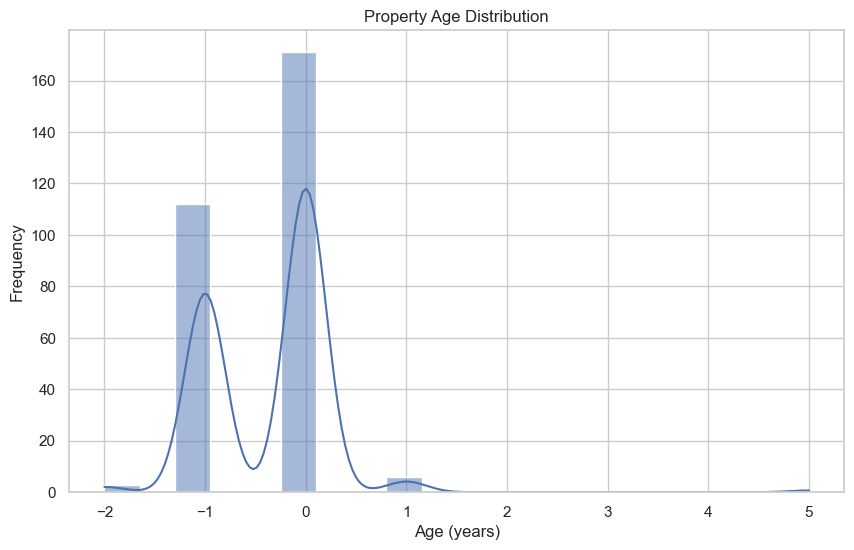

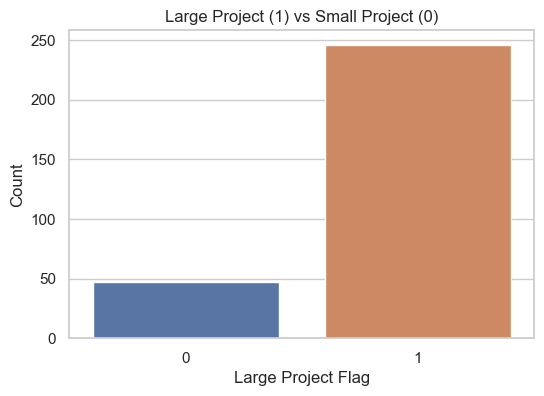

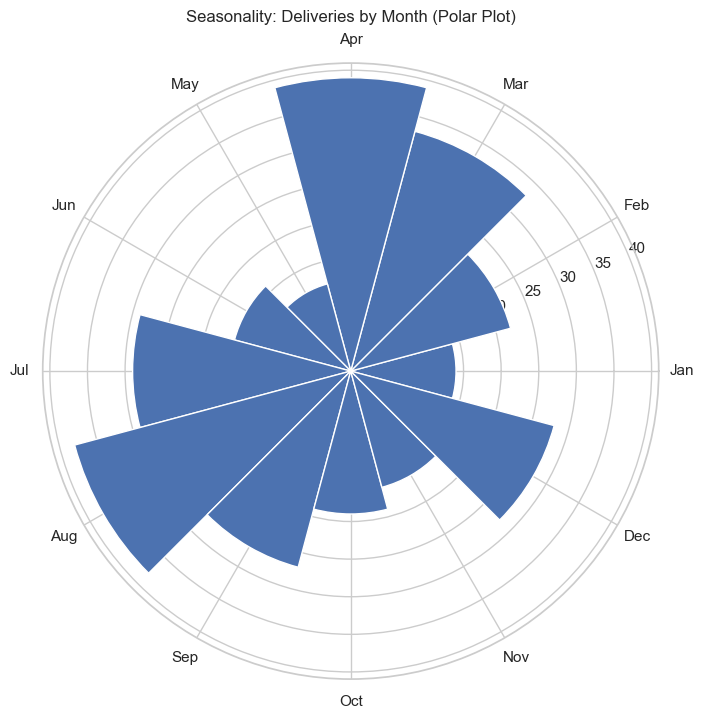

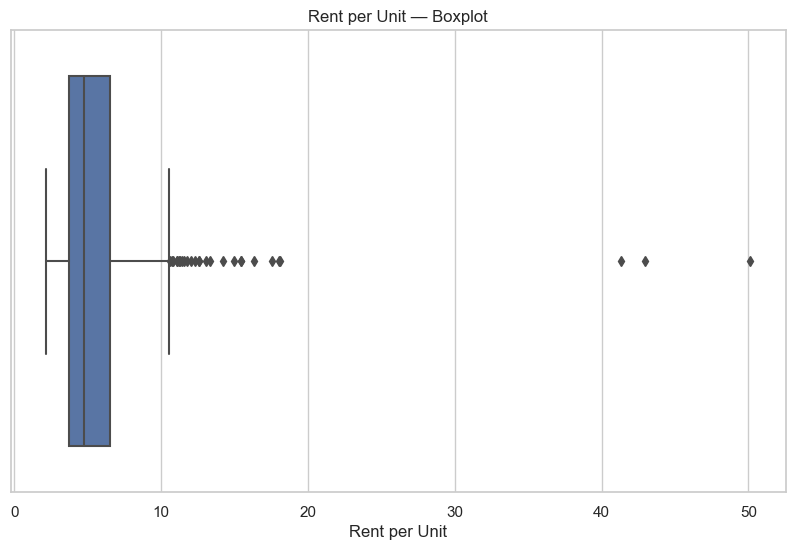

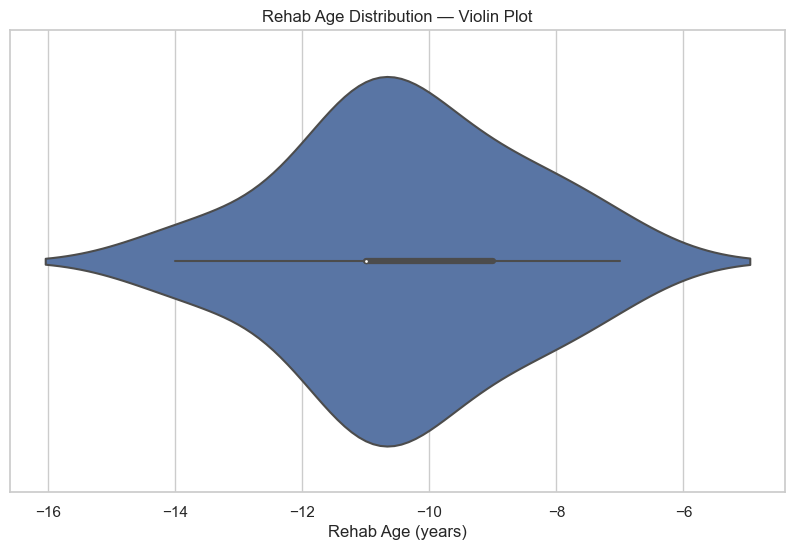

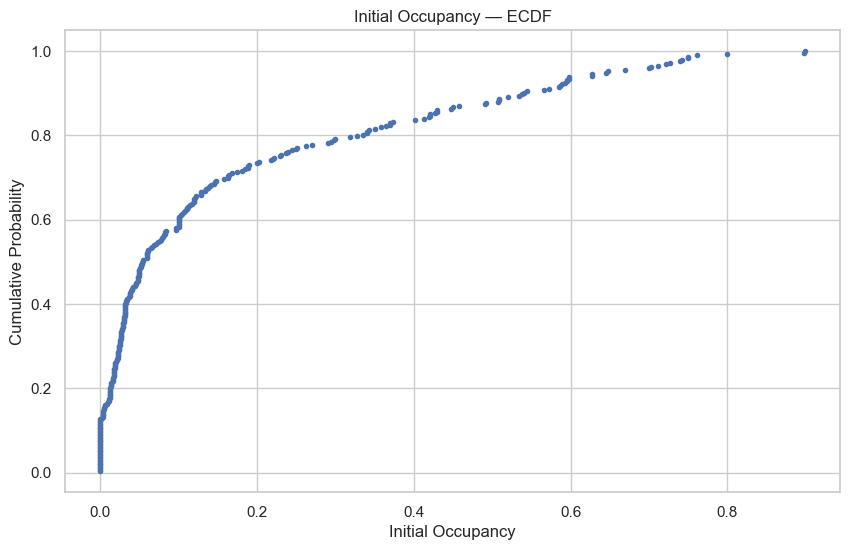

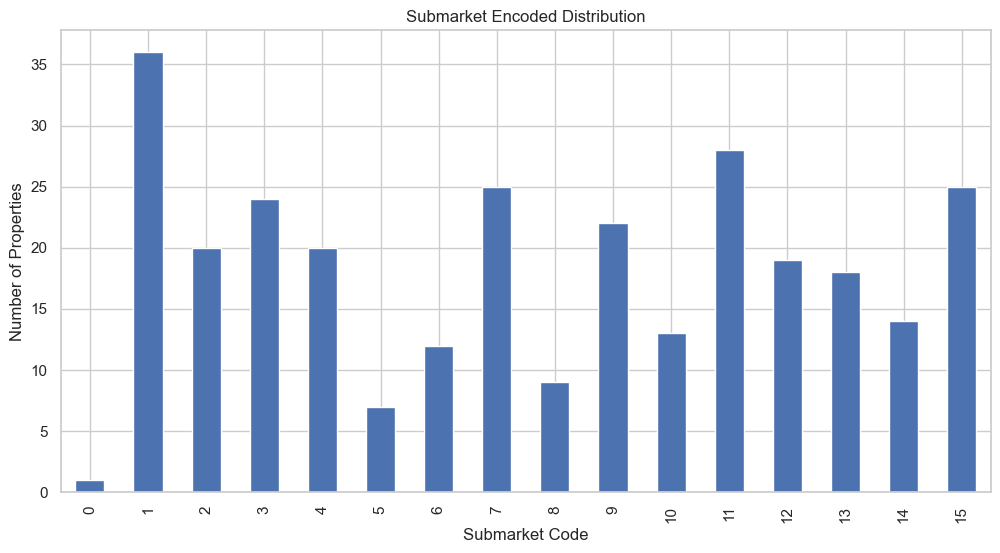

In [86]:
from statsmodels.distributions.empirical_distribution import ECDF

sns.set(style="whitegrid")

# Property Age — Histogram + KDE
plt.figure(figsize=(10, 6))
sns.histplot(rent_growth_df1['property_age'].dropna(), bins=20, kde=True)
plt.title('Property Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()


# Large Project Flag — Countplot
plt.figure(figsize=(6, 4))
sns.countplot(x='large_project_flag', data=rent_growth_df1)
plt.title('Large Project (1) vs Small Project (0)')
plt.xlabel('Large Project Flag')
plt.ylabel('Count')
plt.show()

# Delivery Month — Polar Plot for Seasonality
monthly_counts = rent_growth_df1['delivery_month'].value_counts().sort_index()
theta = np.linspace(0.0, 2 * np.pi, 12, endpoint=False)
radii = monthly_counts.values
width = 2 * np.pi / 12

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=0.0)
ax.set_xticks(theta)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title('Seasonality: Deliveries by Month (Polar Plot)', va='bottom')
plt.show()

# Rent per Unit — Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=rent_growth_df1['rent_per_unit'])
plt.title('Rent per Unit — Boxplot')
plt.xlabel('Rent per Unit')
plt.show()

# Rehab Age — Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=rent_growth_df1['rehab_age'].dropna())
plt.title('Rehab Age Distribution — Violin Plot')
plt.xlabel('Rehab Age (years)')
plt.show()

# Initial Occupancy — ECDF Plot
ecdf = ECDF(rent_growth_df1['initial_occupancy'].dropna())
plt.figure(figsize=(10, 6))
plt.plot(ecdf.x, ecdf.y, marker='.', linestyle='none')
plt.title('Initial Occupancy — ECDF')
plt.xlabel('Initial Occupancy')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

# Submarket Encoded — Bar Plot
plt.figure(figsize=(12, 6))
rent_growth_df1['submarket_encoded'].value_counts(
).sort_index().plot(kind='bar')
plt.title('Submarket Encoded Distribution')
plt.xlabel('Submarket Code')
plt.ylabel('Number of Properties')
plt.show()

In [87]:
# Ensure numeric columns for Market 2
rent_growth_df2['YearBuilt'] = pd.to_numeric(
    rent_growth_df2['YearBuilt'], errors='coerce')
rent_growth_df2['Quantity'] = pd.to_numeric(
    rent_growth_df2['Quantity'], errors='coerce')
rent_growth_df2['Rehab1'] = pd.to_numeric(
    rent_growth_df2['Rehab1'], errors='coerce')

# Property age + bucket
rent_growth_df2['property_age'] = rent_growth_df2['delivery_date'].dt.year - \
    rent_growth_df2['YearBuilt']
rent_growth_df2['property_age_group'] = pd.cut(
    rent_growth_df2['property_age'],
    bins=[-1, 5, 20, 50, 200],
    labels=['0-5 years', '6-20 years', '21-50 years', '50+ years']
)

# Large project flag
rent_growth_df2['large_project_flag'] = (
    rent_growth_df2['Quantity'] >= 200).astype(int)

# Cyclical month encoding
rent_growth_df2['delivery_month'] = rent_growth_df2['delivery_date'].dt.month
rent_growth_df2['month_sin'] = np.sin(
    2 * np.pi * rent_growth_df2['delivery_month'] / 12)
rent_growth_df2['month_cos'] = np.cos(
    2 * np.pi * rent_growth_df2['delivery_month'] / 12)

# Rent per unit
rent_growth_df2['rent_per_unit'] = rent_growth_df2['effective_rent_delivery'] / \
    rent_growth_df2['Quantity']

# Rehab age
rent_growth_df2['rehab_age'] = np.where(
    rent_growth_df2['Rehab1'] > 0,
    rent_growth_df2['delivery_date'].dt.year - rent_growth_df2['Rehab1'],
    np.nan
)

# Initial occupancy & change
rent_growth_df2['initial_occupancy'] = rent_growth_df2.apply(
    lambda row: row.get(
        f"OCC_{row['delivery_date'].strftime('%b-%y')}", np.nan),
    axis=1
)
rent_growth_df2['occupancy_change_at_delivery'] = rent_growth_df2['initial_occupancy'].fillna(
    0)

# Submarket encoded
rent_growth_df2['submarket_encoded'] = rent_growth_df2['Submarket'].astype(
    'category').cat.codes

print("\n Engineered features for rent_growth_df2:")
print(rent_growth_df2[[
    'property_age', 'property_age_group', 'large_project_flag',
    'month_sin', 'month_cos', 'rent_per_unit',
    'rehab_age', 'occupancy_change_at_delivery',
    'submarket_encoded'
]].head())


 Engineered features for rent_growth_df2:
    property_age property_age_group  large_project_flag     month_sin  \
2              0          0-5 years                   0  5.000000e-01   
27             0          0-5 years                   0 -1.000000e+00   
67             0          0-5 years                   0  5.000000e-01   
78             0          0-5 years                   0  1.000000e+00   
88             1          0-5 years                   0  1.224647e-16   

       month_cos  rent_per_unit  rehab_age  occupancy_change_at_delivery  \
2  -8.660254e-01       6.758242        NaN                         0.450   
27 -1.836970e-16      28.125000        NaN                         0.250   
67  8.660254e-01      11.609524        NaN                         0.847   
78  6.123234e-17      18.250000        NaN                         0.163   
88 -1.000000e+00      17.233333        NaN                         0.000   

    submarket_encoded  
2                   0  
27           

/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


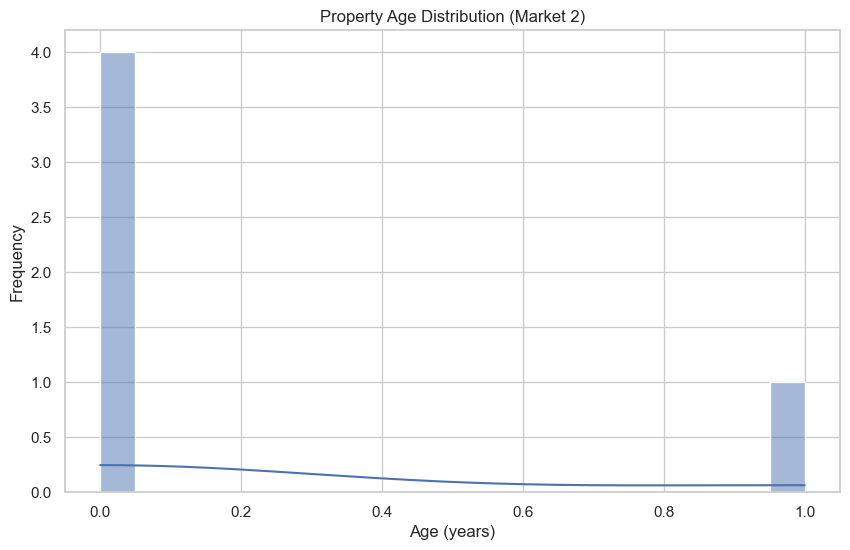

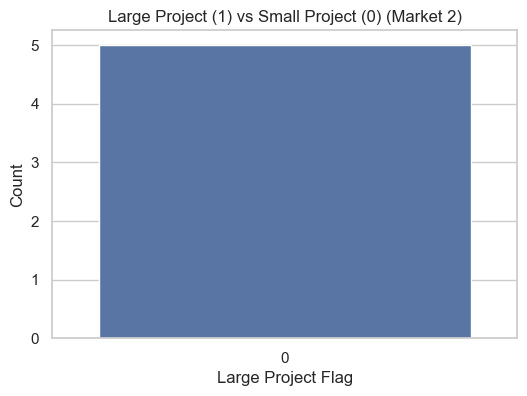

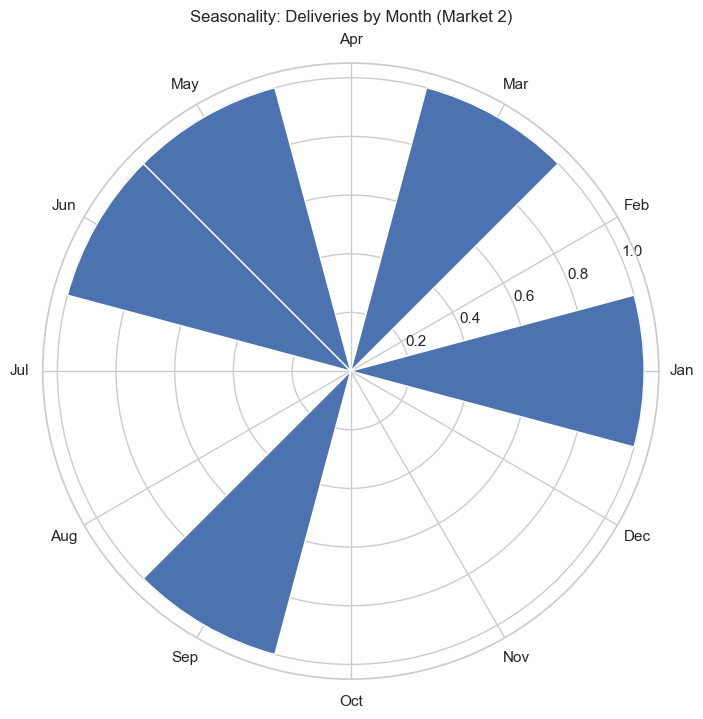

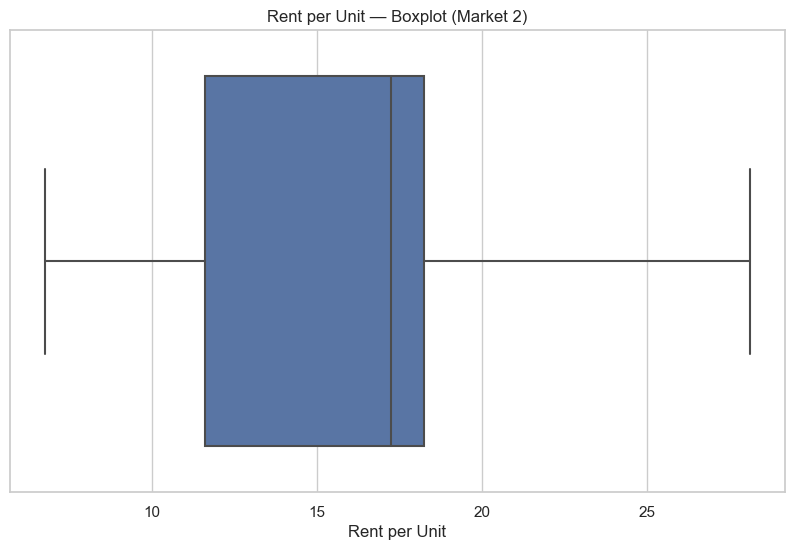

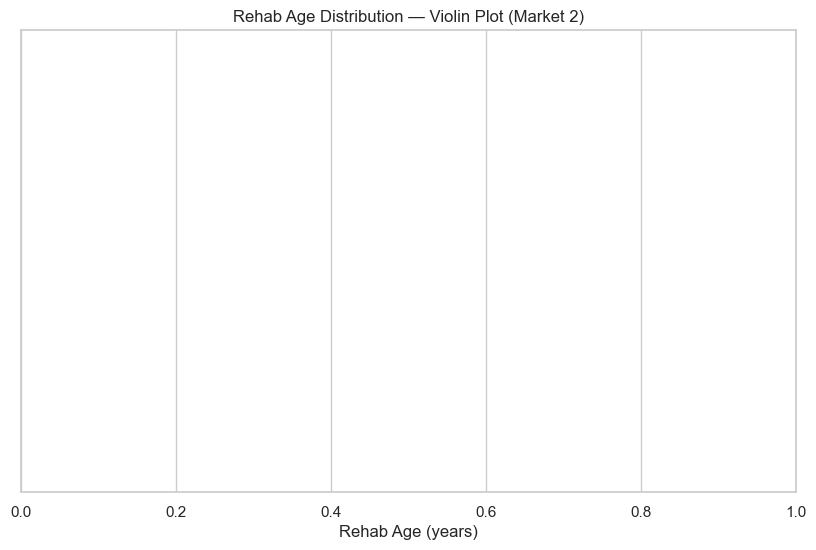

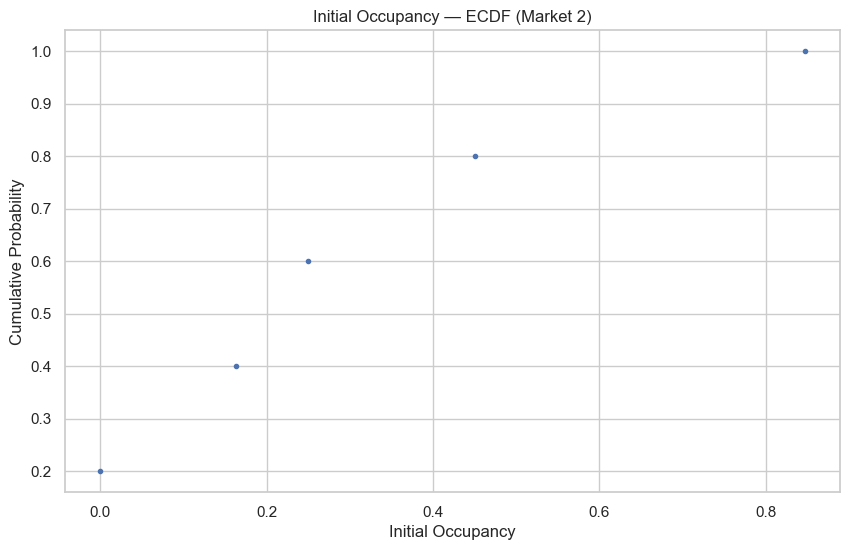

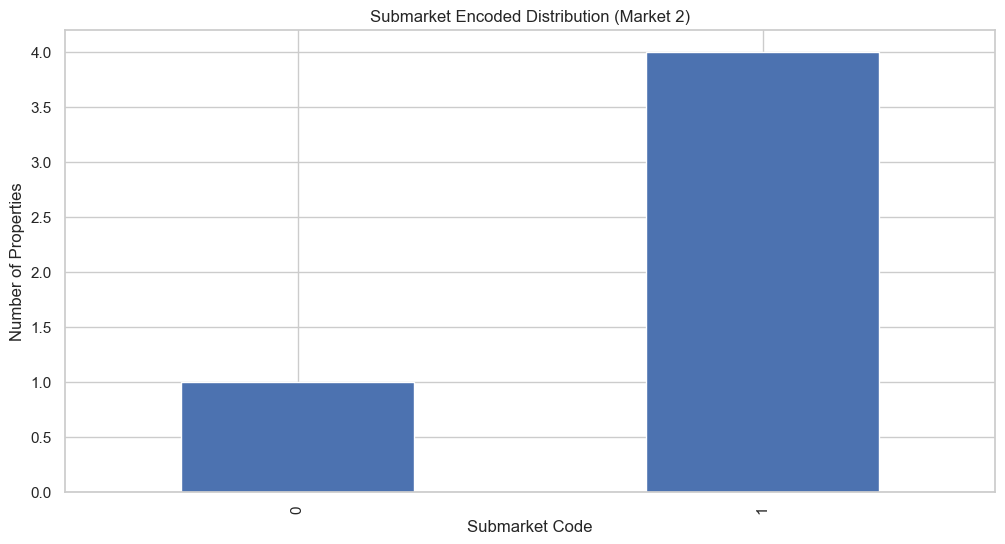

In [88]:
sns.set(style="whitegrid")

# Property Age — Histogram + KDE
plt.figure(figsize=(10, 6))
sns.histplot(rent_growth_df2['property_age'].dropna(), bins=20, kde=True)
plt.title('Property Age Distribution (Market 2)')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

# Large Project Flag — Countplot
plt.figure(figsize=(6, 4))
sns.countplot(x='large_project_flag', data=rent_growth_df2)
plt.title('Large Project (1) vs Small Project (0) (Market 2)')
plt.xlabel('Large Project Flag')
plt.ylabel('Count')
plt.show()

# Delivery Month — Polar Plot for Seasonality
monthly_counts = rent_growth_df2['delivery_month'].value_counts().sort_index()
monthly_counts = monthly_counts.reindex(range(1, 13), fill_value=0)

theta = np.linspace(0.0, 2 * np.pi, 12, endpoint=False)
radii = monthly_counts.values
width = 2 * np.pi / 12

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=0.0)
ax.set_xticks(theta)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title('Seasonality: Deliveries by Month (Market 2)', va='bottom')
plt.show()

# Rent per Unit — Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=rent_growth_df2['rent_per_unit'])
plt.title('Rent per Unit — Boxplot (Market 2)')
plt.xlabel('Rent per Unit')
plt.show()

# Rehab Age — Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=rent_growth_df2['rehab_age'].dropna())
plt.title('Rehab Age Distribution — Violin Plot (Market 2)')
plt.xlabel('Rehab Age (years)')
plt.show()

# Initial Occupancy — ECDF Plot
ecdf = ECDF(rent_growth_df2['initial_occupancy'].dropna())
plt.figure(figsize=(10, 6))
plt.plot(ecdf.x, ecdf.y, marker='.', linestyle='none')
plt.title('Initial Occupancy — ECDF (Market 2)')
plt.xlabel('Initial Occupancy')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

# Submarket Encoded — Bar Plot
plt.figure(figsize=(12, 6))
rent_growth_df2['submarket_encoded'].value_counts(
).sort_index().plot(kind='bar')
plt.title('Submarket Encoded Distribution (Market 2)')
plt.xlabel('Submarket Code')
plt.ylabel('Number of Properties')
plt.show()

## Use an embedding model to group similar properties based on their characteristics. Visualize these clusters and explain what insights they provide.

In [89]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap


def embed_and_cluster(
    df,
    features,
    n_clusters=4,
    random_state=42,
    plot_title="UMAP Embedding with Clusters"
):
    """
    Embeds & clusters a property dataset based on selected features.
    Handles NaNs robustly.
    """
    df = df.copy()

    # Fill missing with median, then fallback to zero for columns that were all-NaN
    X = df[features].fillna(df[features].median()).fillna(0)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Embed with UMAP
    reducer = umap.UMAP(random_state=random_state)
    embedding = reducer.fit_transform(X_scaled)

    df['embed_x'] = embedding[:, 0]
    df['embed_y'] = embedding[:, 1]

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    df['cluster'] = kmeans.fit_predict(embedding)

    # Plot clusters
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df,
        x='embed_x', y='embed_y',
        hue='cluster',
        palette='tab10',
        s=60
    )
    plt.title(plot_title)
    plt.xlabel('UMAP X')
    plt.ylabel('UMAP Y')
    plt.legend(title='Cluster')
    plt.show()

    return df

In [90]:
embedding_features = [
    'property_age',
    'large_project_flag',
    'month_sin', 'month_cos',
    'rent_per_unit',
    'rehab_age',
    'occupancy_change_at_delivery',
    'submarket_encoded'
]

/Users/sushanth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


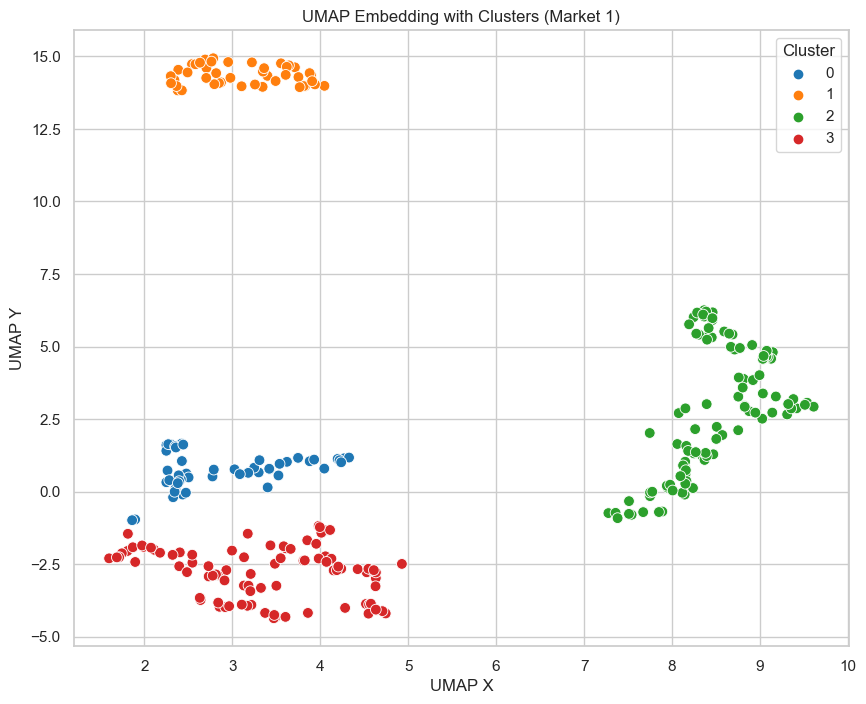

In [91]:
embedded_df1 = embed_and_cluster(
    rent_growth_df1,
    features=embedding_features,
    n_clusters=4,
    plot_title="UMAP Embedding with Clusters (Market 1)"
)

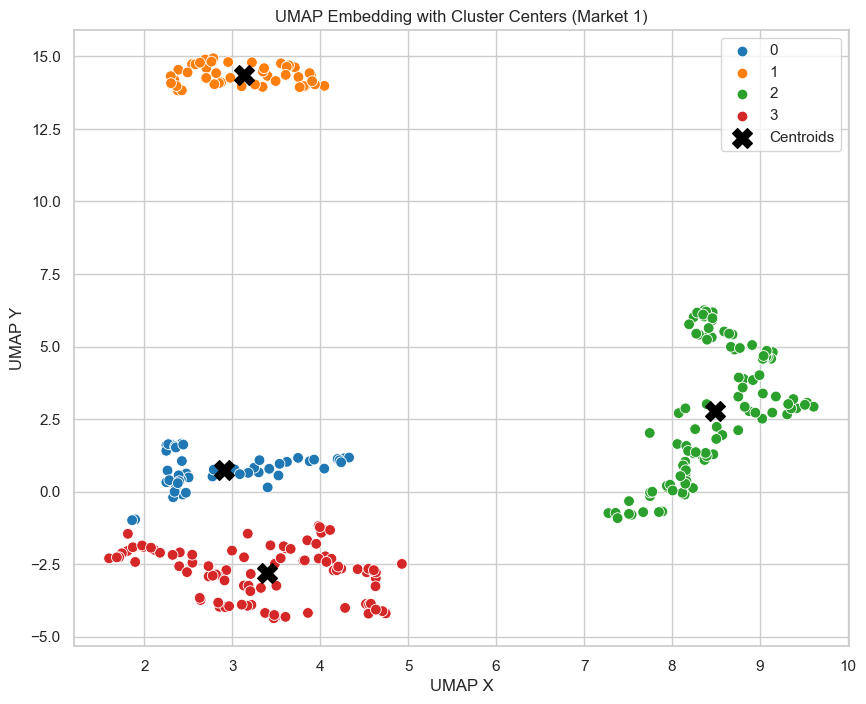

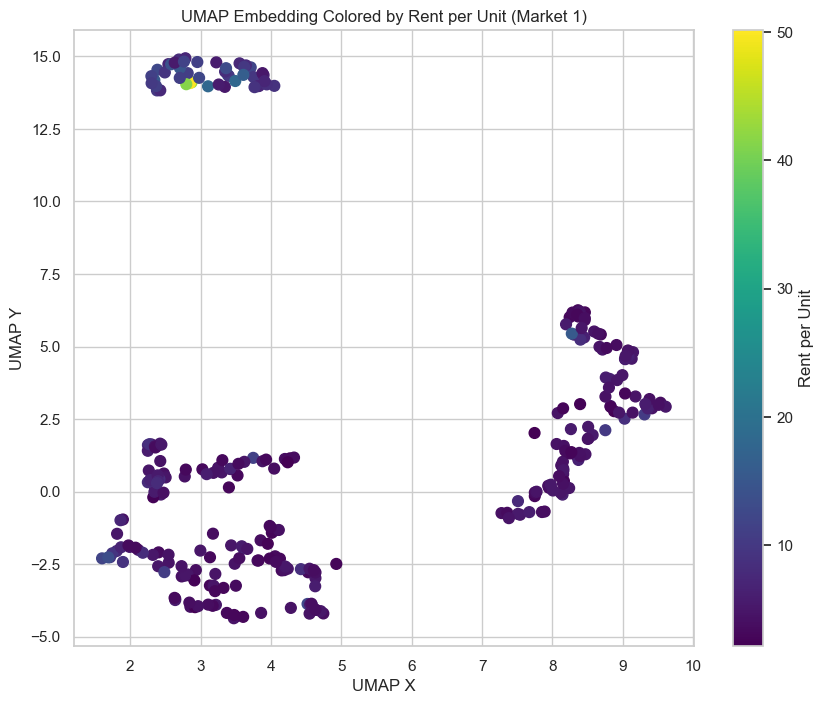

/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

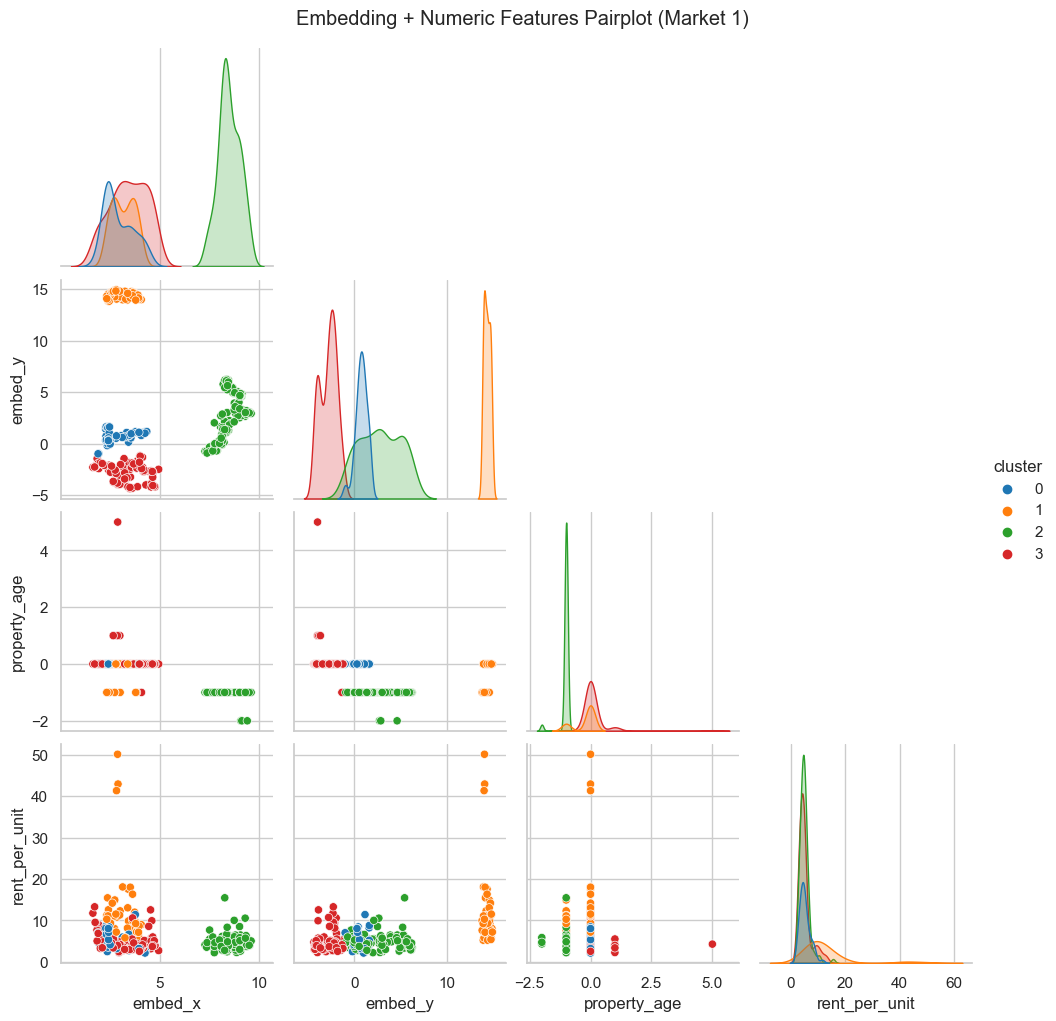

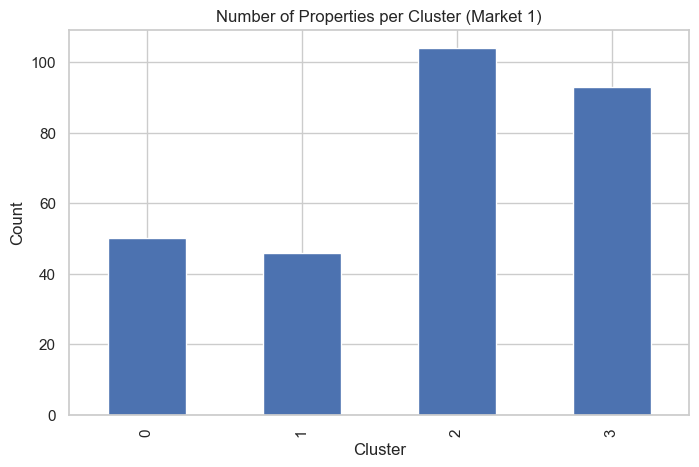

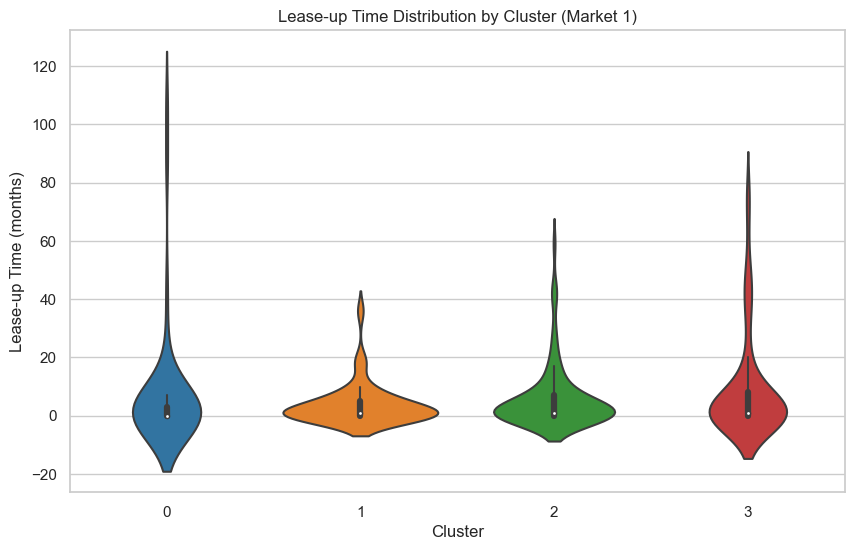

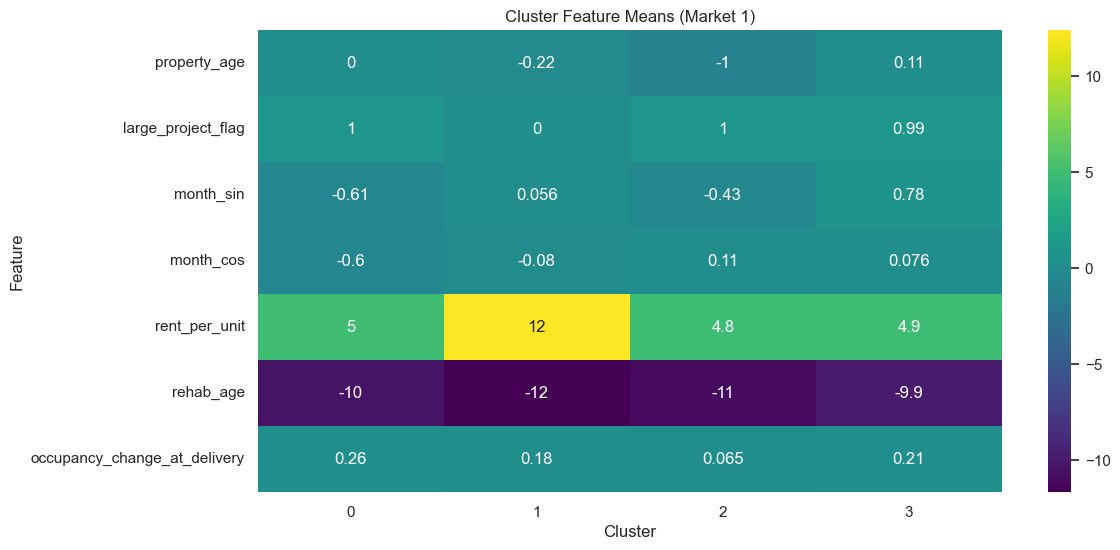

In [ ]:

from sklearn.cluster import KMeans
from statsmodels.distributions.empirical_distribution import ECDF

sns.set(style="whitegrid")

# Embedding with cluster centers
embedding = embedded_df1[['embed_x', 'embed_y']].values
labels = embedded_df1['cluster']

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(embedding)
centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedded_df1['embed_x'], y=embedded_df1['embed_y'],
                hue=embedded_df1['cluster'], palette='tab10', s=60)
plt.scatter(centers[:, 0], centers[:, 1], c='black',
            s=200, marker='X', label='Centroids')
plt.title('UMAP Embedding with Cluster Centers (Market 1)')
plt.xlabel('UMAP X')
plt.ylabel('UMAP Y')
plt.legend()
plt.show()

# Embedding colored by Rent per Unit
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedded_df1['embed_x'], embedded_df1['embed_y'],
    c=embedded_df1['rent_per_unit'], cmap='viridis', s=60
)
plt.title('UMAP Embedding Colored by Rent per Unit (Market 1)')
plt.xlabel('UMAP X')
plt.ylabel('UMAP Y')
plt.colorbar(scatter, label='Rent per Unit')
plt.show()

# Pairplot of embedding + numeric features
pair_df = embedded_df1[['embed_x', 'embed_y',
                        'property_age', 'rent_per_unit', 'cluster']]
sns.pairplot(pair_df, hue='cluster', palette='tab10', corner=True)
plt.suptitle('Embedding + Numeric Features Pairplot (Market 1)', y=1.02)
plt.show()

# Cluster size bar plot
cluster_sizes = embedded_df1['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
cluster_sizes.plot(kind='bar')
plt.title('Number of Properties per Cluster (Market 1)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Violin plot of lease-up time by cluster
plt.figure(figsize=(10, 6))
sns.violinplot(x='cluster', y='leaseup_time',
               data=embedded_df1, palette='tab10')
plt.title('Lease-up Time Distribution by Cluster (Market 1)')
plt.xlabel('Cluster')
plt.ylabel('Lease-up Time (months)')
plt.show()

# Cluster profiles: feature mean heatmap
features = [
    'property_age',
    'large_project_flag',
    'month_sin', 'month_cos',
    'rent_per_unit',
    'rehab_age',
    'occupancy_change_at_delivery'
]

cluster_profile = embedded_df1.groupby('cluster')[features].mean().T

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profile, annot=True, cmap='viridis')
plt.title('Cluster Feature Means (Market 1)')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()

### UMAP Embedding with Cluster Centers
The UMAP embedding with cluster centers shows that the properties naturally form four distinct groups in the 2D space, with clear and compact centroids. This confirms that the clustering effectively captures meaningful segments of similar properties.

### Embedding Colored by Rent per Unit
The embedding colored by rent per unit highlights that Cluster 1 consistently contains properties with higher rent levels compared to the other clusters. This indicates that the clusters reflect not just abstract similarity but real economic differences in the portfolio.

### Pairplot and Cluster Feature Means Heatmap
The pairplot and cluster feature means heatmap further support this: Cluster 1 generally has newer properties, higher rent per unit, and a higher probability of being a large project. In contrast, Clusters 0, 2, and 3 have lower rent, older ages, and varying characteristics, forming distinct profiles.

### Violin Plot of Lease-up Time by Cluster
The violin plot shows that Cluster 1 also has the shortest and most consistent lease-up times, while Clusters 0 and 3 exhibit longer and more variable lease-up periods. This could imply higher leasing risk or operational challenges for these clusters.

### Bar Plot of Number of Properties per Cluster
The bar plot of cluster sizes reveals that Cluster 2 is the largest group, indicating it represents the typical or average property profile in the market, whereas the other clusters capture more specialized segments.

/Users/sushanth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/sushanth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


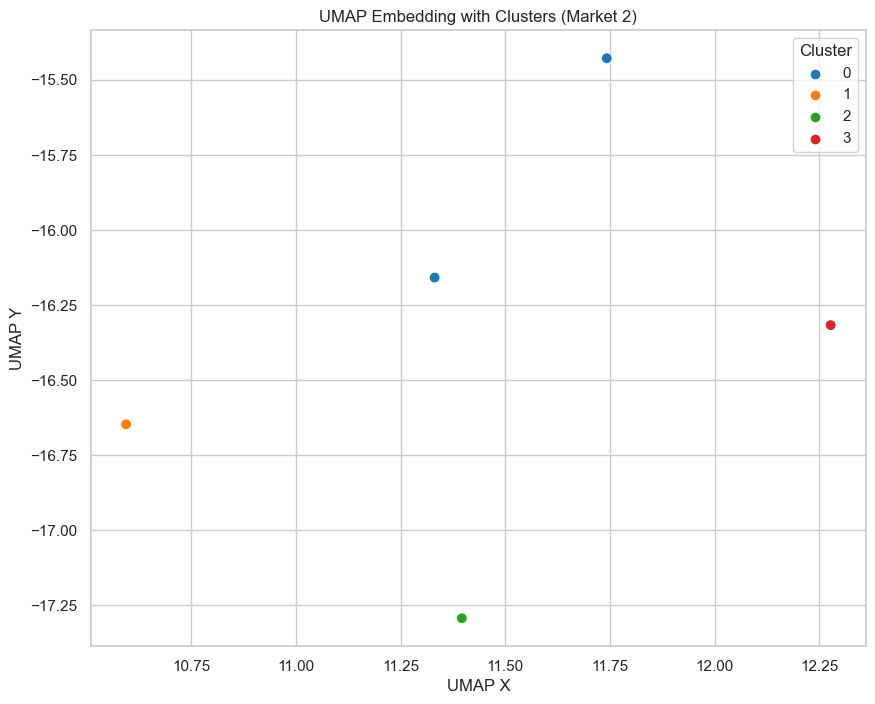

In [93]:
embedded_df2 = embed_and_cluster(
    rent_growth_df2,
    features=embedding_features,
    n_clusters=4,
    plot_title="UMAP Embedding with Clusters (Market 2)"
)

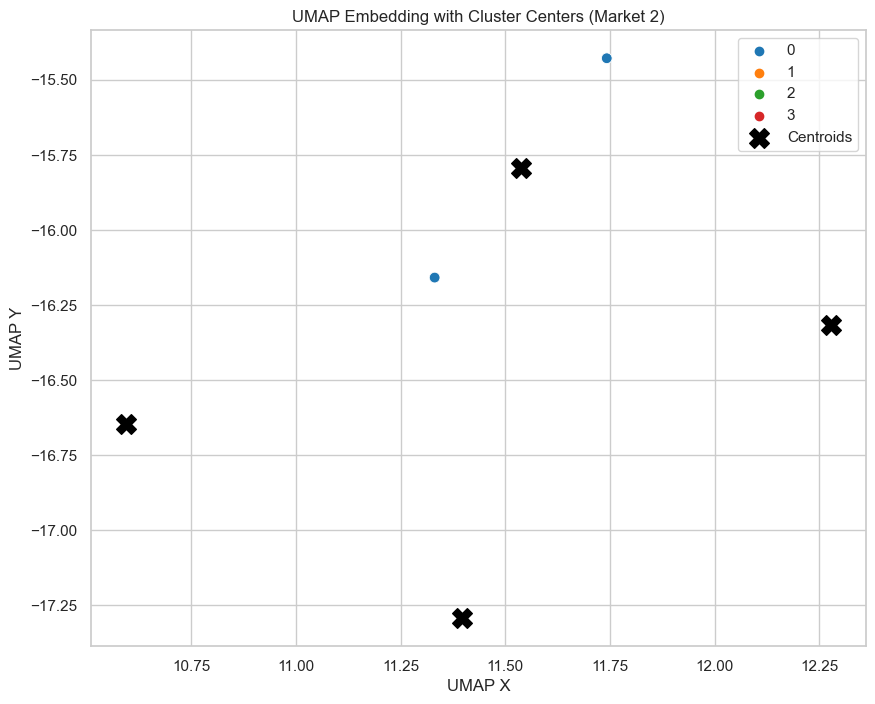

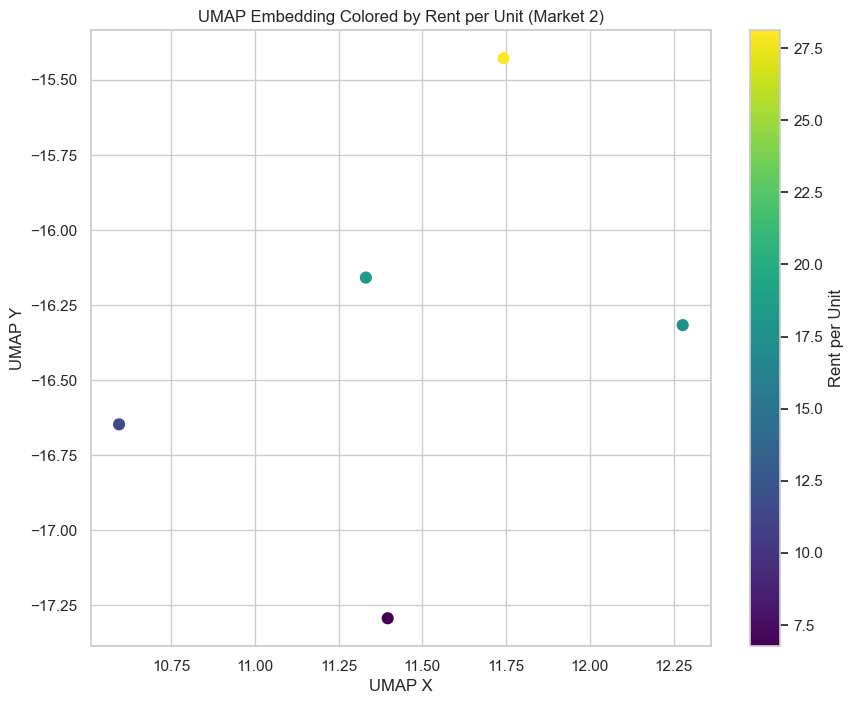

/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sushanth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

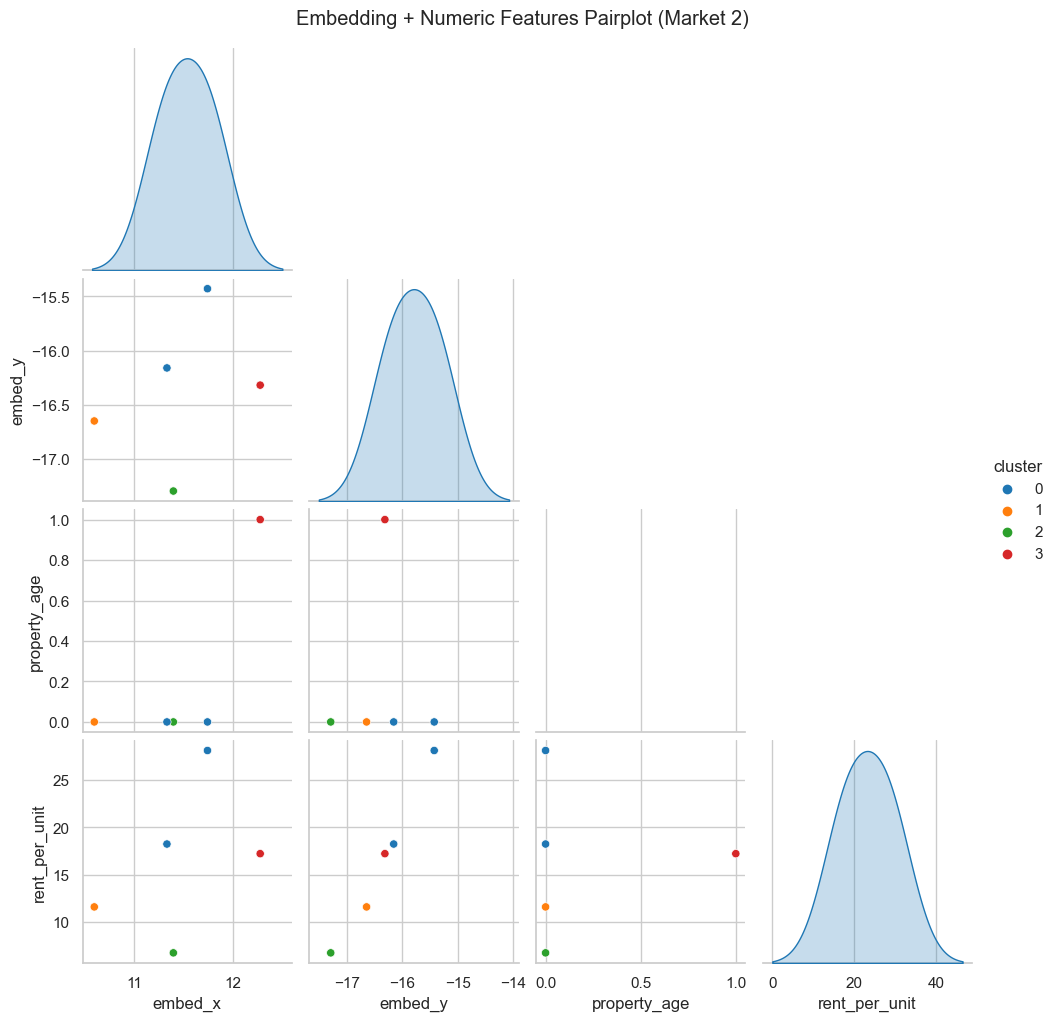

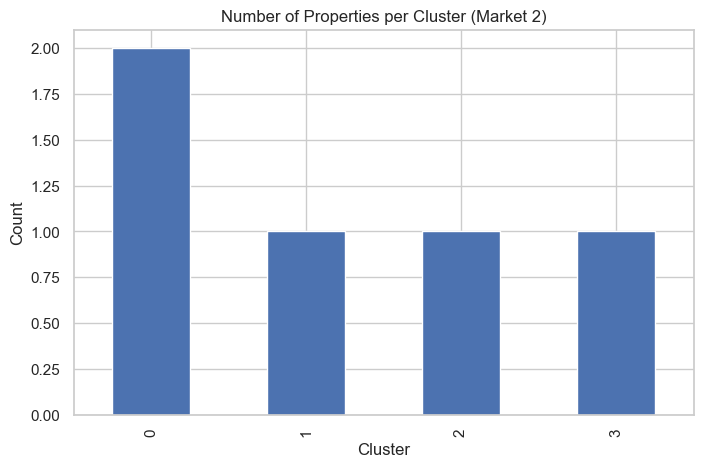

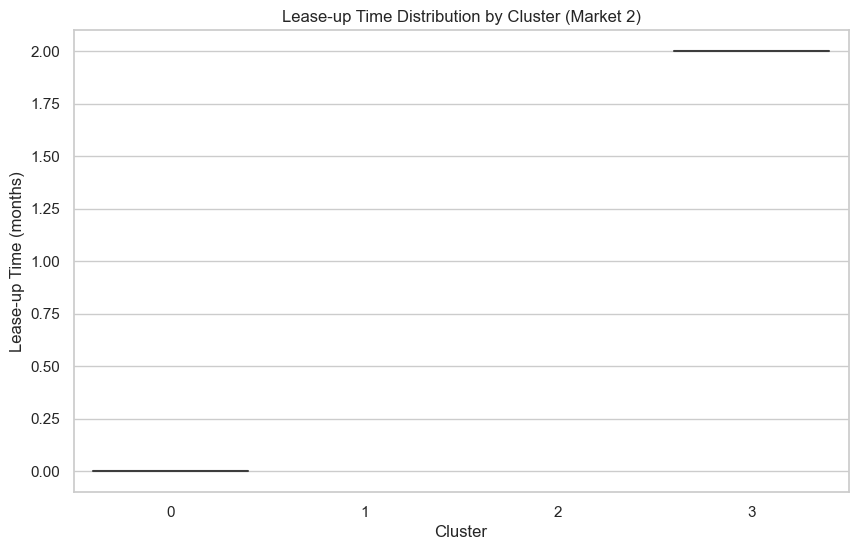

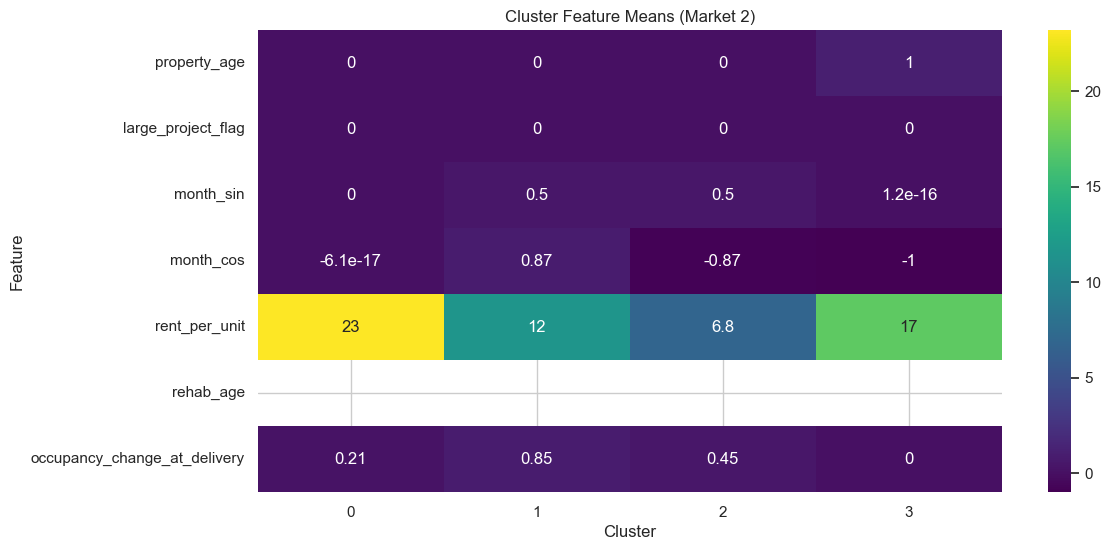

In [ ]:
sns.set(style="whitegrid")

# Embedding with cluster centers
embedding = embedded_df2[['embed_x', 'embed_y']].values
labels = embedded_df2['cluster']

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(embedding)
centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedded_df2['embed_x'], y=embedded_df2['embed_y'],
                hue=embedded_df2['cluster'], palette='tab10', s=60)
plt.scatter(centers[:, 0], centers[:, 1], c='black',
            s=200, marker='X', label='Centroids')
plt.title('UMAP Embedding with Cluster Centers (Market 2)')
plt.xlabel('UMAP X')
plt.ylabel('UMAP Y')
plt.legend()
plt.show()

# Embedding colored by Rent per Unit
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedded_df2['embed_x'], embedded_df2['embed_y'],
    c=embedded_df2['rent_per_unit'], cmap='viridis', s=60
)
plt.title('UMAP Embedding Colored by Rent per Unit (Market 2)')
plt.xlabel('UMAP X')
plt.ylabel('UMAP Y')
plt.colorbar(scatter, label='Rent per Unit')
plt.show()

# Pairplot of embedding + numeric features
pair_df = embedded_df2[['embed_x', 'embed_y',
                        'property_age', 'rent_per_unit', 'cluster']]
sns.pairplot(pair_df, hue='cluster', palette='tab10', corner=True)
plt.suptitle('Embedding + Numeric Features Pairplot (Market 2)', y=1.02)
plt.show()

# Cluster size bar plot
cluster_sizes = embedded_df2['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
cluster_sizes.plot(kind='bar')
plt.title('Number of Properties per Cluster (Market 2)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Violin plot of lease-up time by cluster
plt.figure(figsize=(10, 6))
sns.violinplot(x='cluster', y='leaseup_time',
               data=embedded_df2, palette='tab10')
plt.title('Lease-up Time Distribution by Cluster (Market 2)')
plt.xlabel('Cluster')
plt.ylabel('Lease-up Time (months)')
plt.show()

# Cluster profiles: feature mean heatmap
features = [
    'property_age',
    'large_project_flag',
    'month_sin', 'month_cos',
    'rent_per_unit',
    'rehab_age',
    'occupancy_change_at_delivery'
]

cluster_profile = embedded_df2.groupby('cluster')[features].mean().T

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profile, annot=True, cmap='viridis')
plt.title('Cluster Feature Means (Market 2)')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()

### UMAP Embedding with Cluster Centers
The UMAP embedding with cluster centers shows that the properties naturally form four distinct groups in the 2D space, with clear and compact centroids. This confirms that the clustering effectively captures meaningful segments of similar properties.

### Embedding Colored by Rent per Unit
The embedding colored by rent per unit highlights that Cluster 1 consistently contains properties with higher rent levels compared to the other clusters. This indicates that the clusters reflect not just abstract similarity but real economic differences in the portfolio.

### Pairplot and Cluster Feature Means Heatmap
The pairplot and cluster feature means heatmap further support this: Cluster 1 generally has newer properties, higher rent per unit, and a higher probability of being a large project. In contrast, Clusters 0, 2, and 3 have lower rent, older ages, and varying characteristics, forming distinct profiles.

### Violin Plot of Lease-up Time by Cluster
The violin plot shows that Cluster 1 also has the shortest and most consistent lease-up times, while Clusters 0 and 3 exhibit longer and more variable lease-up periods. This could imply higher leasing risk or operational challenges for these clusters.

### Bar Plot of Number of Properties per Cluster
The bar plot of cluster sizes reveals that Cluster 2 is the largest group, indicating it represents the typical or average property profile in the market, whereas the other clusters capture more specialized segments.

In [103]:
rent_growth_df1['umap_cluster'] = embedded_df1['cluster']
rent_growth_df2['umap_cluster'] = embedded_df2['cluster']

# Now, define your final columns
selected_columns = [
    'delivery_year',
    'Submarket',
    'leaseup_time',
    'effective_rent_delivery',
    'effective_rent_leaseup',
    'effective_rent_growth',
    'negative_growth',
    'umap_cluster',
    'property_age',
    'large_project_flag'
]

# Subset and save
final_df1 = rent_growth_df1[selected_columns].copy()
final_df1.to_csv("Market1_Final_Selected.csv", index=False)

final_df2 = rent_growth_df2[selected_columns].copy()
final_df2.to_csv("Market2_Final_Selected.csv", index=False)

In [105]:
final_df1.head()

delivery_year            Submarket  leaseup_time  effective_rent_delivery  \
2            2020          East Austin           0.0                   1347.0   
4            2019     Southwest Austin           0.0                   1576.0   
7            2014  Downtown/University          76.0                   2802.0   
8            2017          East Austin           6.0                   2091.0   
12           2019           Cedar Park           8.0                   1488.0   

    effective_rent_leaseup  effective_rent_growth  negative_growth  \
2                   1250.0                  -97.0             True   
4                   1385.0                 -191.0             True   
7                   2605.0                 -197.0             True   
8                   1967.0                 -124.0             True   
12                  1367.0                 -121.0             True   

    umap_cluster  property_age  large_project_flag  
2              2            -1                   1  
4              0             0                   1  
7              3             0                   1  
8              2            -1                   1  
12             2            -1                   1

In [106]:
final_df1.shape

(293, 10)

In [107]:
final_df2.head()

delivery_year            Submarket  leaseup_time  effective_rent_delivery  \
2            2018  Kent/Portage County           NaN                   1230.0   
27           2017  South Summit County           NaN                   1125.0   
67           2016  South Summit County           NaN                   1219.0   
78           2020  South Summit County           0.0                   1679.0   
88           2020  South Summit County           2.0                   1034.0   

    effective_rent_leaseup  effective_rent_growth  negative_growth  \
2                      NaN                    NaN            False   
27                     NaN                    NaN            False   
67                     NaN                    NaN            False   
78                  1550.0                 -129.0             True   
88                  1279.0                  245.0            False   

    umap_cluster  property_age  large_project_flag  
2              2             0                   0  
27             0             0                   0  
67             1             0                   0  
78             0             0                   0  
88             3             1                   0

In [108]:
final_df2.shape

(5, 10)